Chi Zhang

Implementation: Nov 2023, 400 Howard St, San Francisco

All rights reserved.

1. data download, EDA, and preprocessing
2. feature evaluation (random forest) and visualization (manifold learning)
3. baseline model time series analysis solely focused on the 311 data
4. linear predictive models (PLS) and nonlinear family (LSTM) when adding the weather data
5. summary

# 1. data download, EDA, and preprocessing

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import datetime
import re

import torch
import torch.nn as nn
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda', 0)
else:
    device = torch.device('cpu')

In [2]:
device

device(type='cuda', index=0)

In [ ]:
zf = zipfile.ZipFile(zipfile_weather)
data_weather_in = pd.read_csv(zf.open('weather_NY_2010_2018Nov.csv'))

In [ ]:
zf = zipfile.ZipFile(zipfile_311)
data_311_in = pd.read_csv(zf.open('311-2016-2018.csv'))

<ipython-input-4-4a3b2bd7a8cf>:2: DtypeWarning: Columns (8,17,18,20,24,31,32,33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  data_311_in = pd.read_csv(zf.open('311-2016-2018.csv'))


In [ ]:
data_311 = data_311_in.drop(data_311_in.columns[data_311_in.isnull().mean() > 1/5], axis=1)
# drop those columns with larger than threshold missing samples ratio in the universe, since the quality of filling is low

<Axes: title={'center': 'Agency %'}>

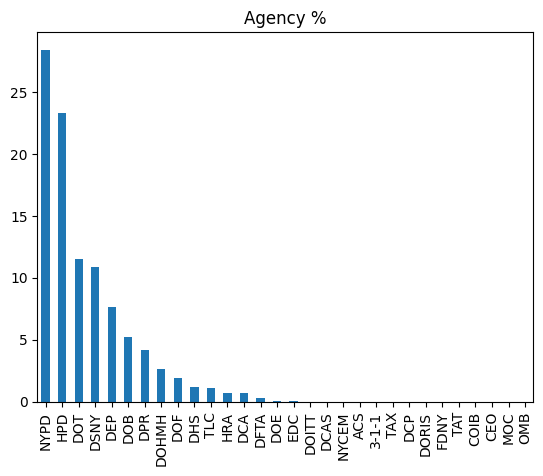

In [ ]:
(data_311['Agency'].value_counts(normalize=True)*100).plot(kind='bar', title='Agency %')

## The NYPD/HPD respond to the majority （～25% each）of 311 calls in New York City. Conversely, the bottom 24 agencies contribute less than 3% each, respond to so few calls that we combined them in a new agency as proxy ('DPR','DOHMH','DOF', 'DHS', 'TLC', 'HRA', 'DCA', 'DFTA', 'DOE', 'EDC', 'DOITT', 'DCAS', 'NYCEM', 'ACS', '3-1-1', 'TAX', 'DCP', 'DORIS', 'FDNY', 'TAT', 'COIB', 'CEO', 'MOC', 'OMB').  

## The new breakdown below looks good in the sense that the 'OTHER' type is still the least frequent one when aggregating from so many raw types.

In [ ]:
data_311.loc[data_311.Agency.isin(['DPR','DOHMH' ,'DOF', 'DHS', 'TLC','HRA', 'DCA', 'DFTA', 'DOE', 'EDC', 'DOITT', 'DCAS', 'NYCEM', 'ACS', '3-1-1', 'TAX', 'DCP', 'DORIS', 'FDNY', 'TAT', 'COIB', 'CEO', 'MOC', 'OMB']), 'Agency'] = 'OTHER'

<Axes: title={'center': 'Agency %'}>

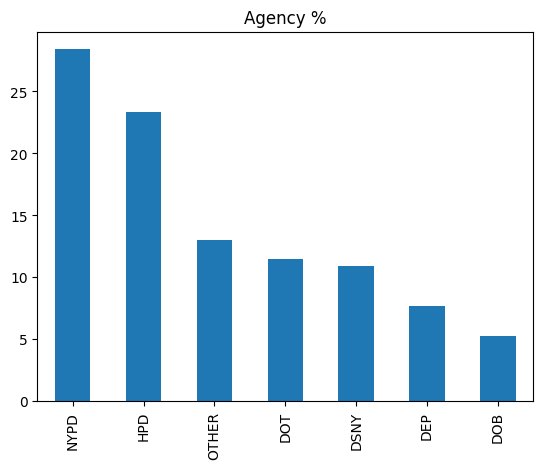

In [ ]:
(data_311['Agency'].value_counts(normalize=True)*100).plot(kind='bar', title='Agency %')

## Similarly, we do some data massaging for other categorical columns: combining less frequent types, remove bad quality samples, remove reduant features carrying similar information, fill missing values and etc.


In [ ]:
data_311 = data_311.loc[data_311.Borough.isin(data_311.Borough.value_counts().index[:-2])]

<Axes: title={'center': 'Borough %'}>

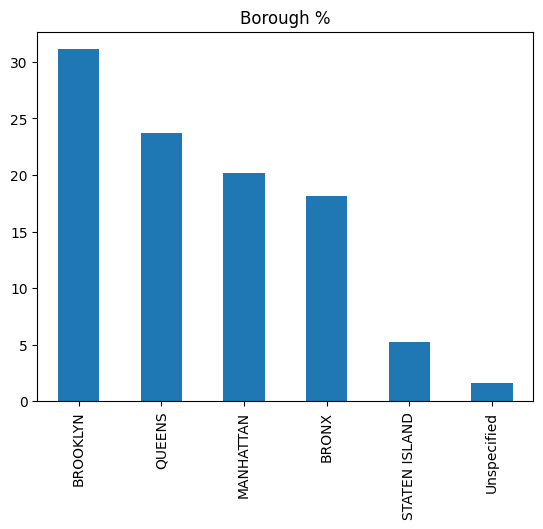

In [ ]:
(data_311['Borough'].value_counts(normalize=True)*100).plot(kind='bar', title='Borough %')

In [ ]:
# eliminate rows without full coverage on location and descriptor features
data_311.dropna(subset=['X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Latitude', 'Longitude', 'Descriptor'], how= 'any', inplace=True)

In [ ]:
data_311['Complaint Type'] = data_311['Complaint Type'].str.title()

In [ ]:
data_311['Descriptor'] = data_311['Descriptor'].str.title()

In [ ]:
data_311 = data_311[['Created Date','Closed Date','Agency','Complaint Type','Descriptor','Status','Community Board','Borough',\
                     'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Latitude', 'Longitude']]

In [ ]:
# convert the created date column to date time
data_311['Created Date'] = pd.to_datetime(data_311['Created Date'], format='%m/%d/%Y %I:%M:%S %p')

In [ ]:
data_311.loc[~data_311['Closed Date'].isna(), 'Closed Date'] = pd.to_datetime(data_311.loc[~data_311['Closed Date'].isna(), 'Closed Date'], format='%m/%d/%Y %I:%M:%S %p', errors = 'coerce')

## So far there is almost no missing value in the 311 dataset. The only remaining one is Close Date. We use the (Agency, Borough)-grid level average processing time (Closed-Created) to fill the missing values.

## We take extra care on the Descriptor column only, which brings 1000+ types (instead of the Resolution Description since its content is pretty standarized) and use GloVe to encode the text info to high-dim word embedding. The resulted word embedding could help us understand 200+ types in compliant column.

In [ ]:
tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
glove_model = KeyedVectors.load_word2vec_format(tmp_file)

<ipython-input-24-3dec9205a0fb>:9: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec(glove_file, tmp_file)


In [ ]:
regex = re.compile('[-+;,.\/()\\*// ]+|\\\\')
data_311['Descriptor GloVe'] = data_311['Descriptor'].apply(lambda x: [word.lower() for word in regex.split(x) if word and word.lower() in glove_model.key_to_index.keys()])

<Axes: title={'center': 'Descriptor GloVe %'}>

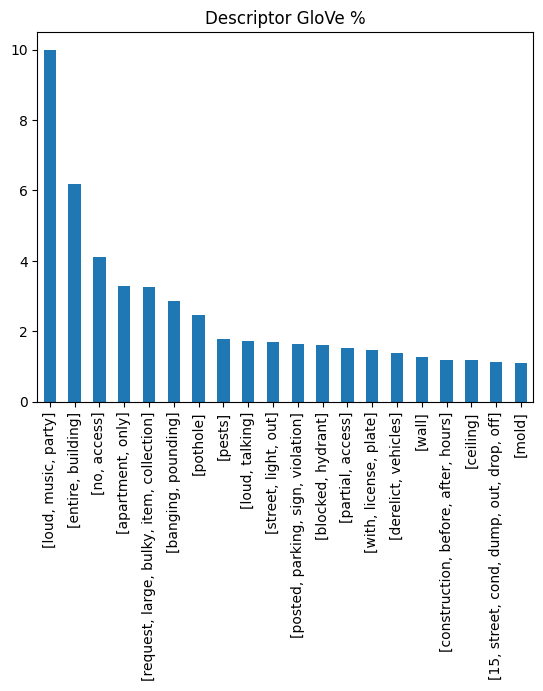

In [ ]:
(data_311['Descriptor GloVe'].value_counts(normalize=True)*100).head(20).plot(kind='bar',title='Descriptor GloVe %')

In [ ]:
data_311['Descriptor Embdng'] = data_311['Descriptor GloVe'].apply(lambda x: glove_model[x].sum(axis=0) if x and len(x)>0 else np.nan)

In [ ]:
data_311['Descriptor Embdng'].fillna(data_311.groupby(['Agency','Borough'])['Descriptor Embdng'].transform('mean'), inplace=True)

In [ ]:
data_311_clean = data_311.copy(deep=True)

In [ ]:
del data_311

In [ ]:
data_311_clean[data_311_clean['Complaint Type'].str.contains('Noise')].groupby(['Agency','Borough','Complaint Type']).size().sort_values(ascending=False).iloc[:22].to_frame()

0
Agency Borough       Complaint Type                 
NYPD   BROOKLYN      Noise - Residential      198167
       BRONX         Noise - Residential      167881
       MANHATTAN     Noise - Residential      148578
       QUEENS        Noise - Residential      132889
       MANHATTAN     Noise - Street/Sidewalk   83985
DEP    MANHATTAN     Noise                     83967
NYPD   BROOKLYN      Noise - Street/Sidewalk   57972
       MANHATTAN     Noise - Commercial        55203
       BROOKLYN      Noise - Commercial        48055
DEP    BROOKLYN      Noise                     46472
NYPD   BRONX         Noise - Street/Sidewalk   42021
DEP    QUEENS        Noise                     31413
NYPD   MANHATTAN     Noise - Vehicle           27125
       BROOKLYN      Noise - Vehicle           23729
       QUEENS        Noise - Commercial        22702
       STATEN ISLAND Noise - Residential       20696
       QUEENS        Noise - Street/Sidewalk   20310
                     Noise - Vehicle           17768
       BRONX         Noise - Vehicle           15902
                     Noise - Commercial        11980
DEP    BRONX         Noise                      9338
       STATEN ISLAND Noise                      5249

(-74.2829521895261, -73.67264218356306, 40.4772993976212, 40.93368538458492)

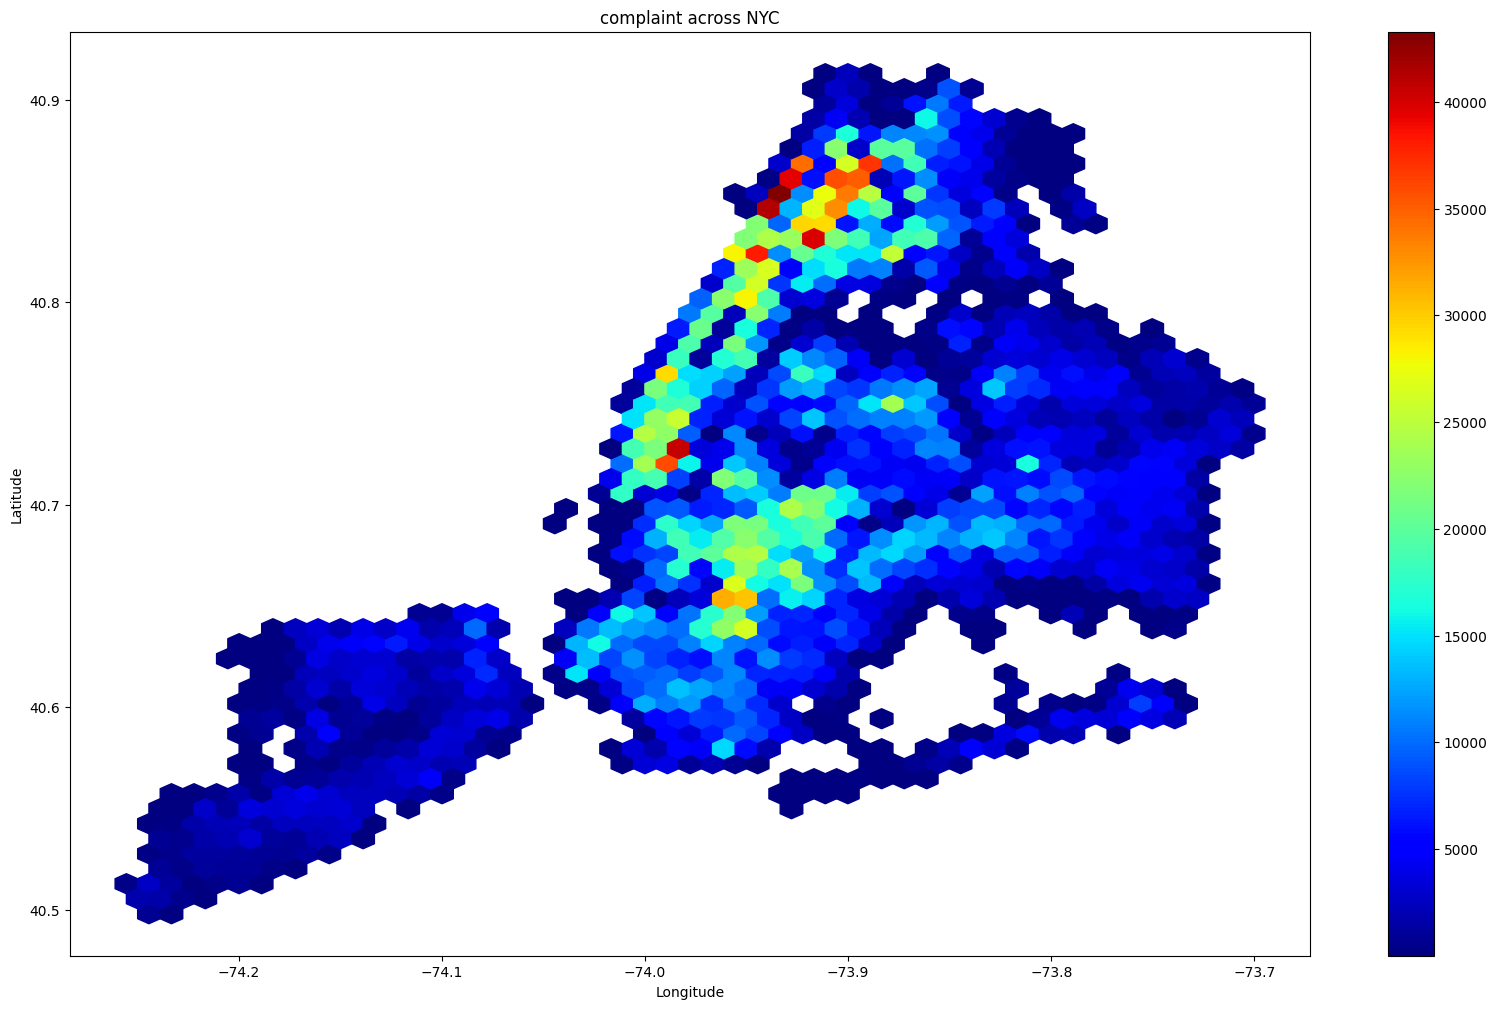

In [ ]:
data_311_clean.plot(kind='hexbin',x='Longitude',y='Latitude',gridsize=50,sharex=False,colormap='jet',mincnt=1,title='complaint across NYC',\
                    figsize=(20,12)).axis('equal')

## seasonality at difference frequency: hour, weekday, month

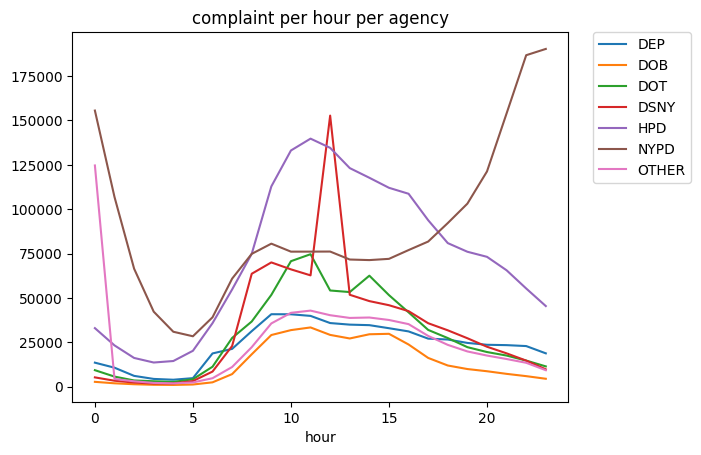

In [ ]:
# plot the trend of the data_311_clean dataframe aggregated by hour per agency
data_311_clean.groupby(['hour','Agency']).size().unstack().plot(kind='line',title='complaint per hour per agency')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

In [ ]:
data_311_clean['IsDayHour'] = data_311_clean['hour'].apply(lambda x: 'Day' if (x>=6 and x<=17) else 'Night')

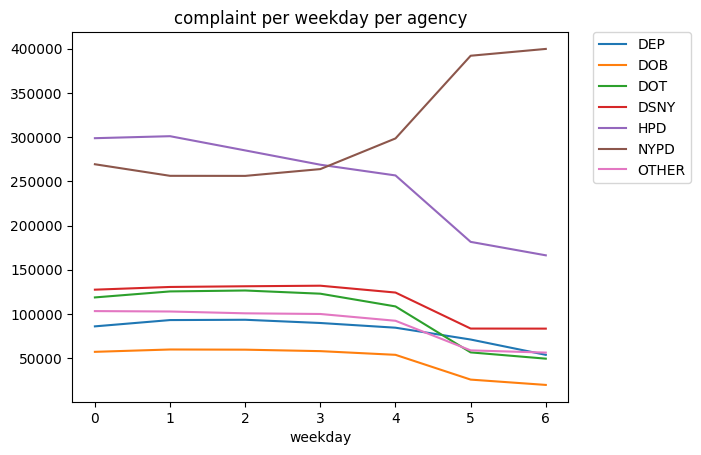

In [ ]:
# plot the trend of the data_311_clean dataframe aggregated by weekday per agency
data_311_clean.groupby(['weekday','Agency']).size().unstack().plot(kind='line',title='complaint per weekday per agency')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

In [ ]:
data_311_clean['IsWeekend'] = data_311_clean['weekday'].apply(lambda x: 'Weekend' if (x>=5) else 'Weekday')

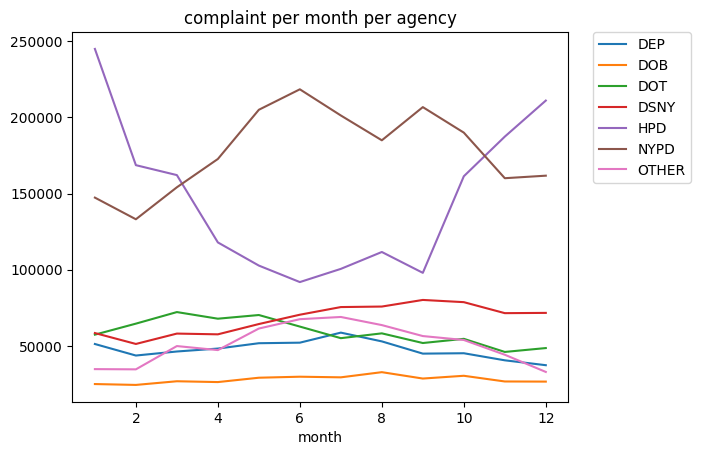

In [ ]:
# plot the trend of the data_311_clean dataframe aggregated by month per agency
tmp_df = data_311_clean.groupby(['month','Agency']).size().unstack()
tmp_df.index = tmp_df.index.astype('int')
tmp_df.sort_index(inplace=True)
tmp_df.plot(kind='line',title='complaint per month per agency')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

In [ ]:
data_311_clean['IsWinter'] = data_311_clean['month'].apply(lambda x: 'Winter' if (int(x)>=10 or int(x)<=3) else 'Summer')

In [ ]:
data_311_clean = pd.get_dummies(data_311_clean, columns=['IsDayHour', 'IsWeekend', 'IsWinter','Agency'])

## for the 2 top agency, we plot the heat map of complaint to see the spatial distribution.

In [ ]:
# calculate the top complaint type category for these two agency: NYPD, HPD.
data_311_clean[data_311_clean['Agency'].isin(['NYPD','HPD'])].groupby(['Agency','Complaint Type']).size().sort_values(ascending=False).iloc[:15].to_frame()

0
Agency Complaint Type                 
NYPD   Noise - Residential      668223
HPD    Heat/Hot Water           658390
NYPD   Illegal Parking          427948
       Blocked Driveway         391037
HPD    Unsanitary Condition     245925
NYPD   Noise - Street/Sidewalk  206837
HPD    Paint/Plaster            176766
       Plumbing                 155705
NYPD   Noise - Commercial       140768
HPD    Door/Window              110528
       Water Leak               103281
NYPD   Derelict Vehicle         102206
       Noise - Vehicle           86544
HPD    Electric                  81385
       General                   77840

In [ ]:
data_311_clean.loc[data_311_clean['Complaint Type'].isin( list((data_311_clean['Complaint Type'].value_counts(normalize=True)*100).tail(100).index) ) , 'Complaint Type'] = 'OTHER'

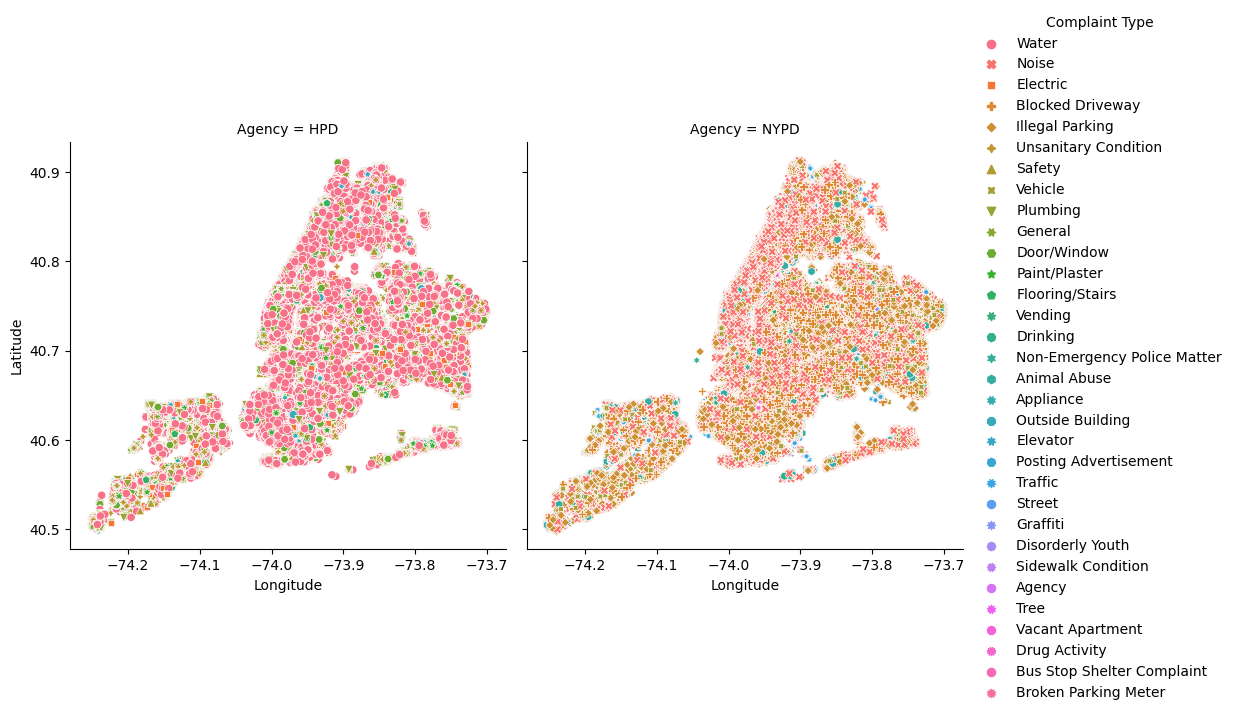

In [ ]:
sns.relplot(x='Longitude',y='Latitude',data=data_311_clean[data_311_clean.Agency.isin(['NYPD','HPD'])],col='Agency',hue='Complaint Type',style='Complaint Type',kind='scatter')

# 2. feature evaluation (random forest) and visualization (manifold learning)

<Figure size 1600x1600 with 0 Axes>

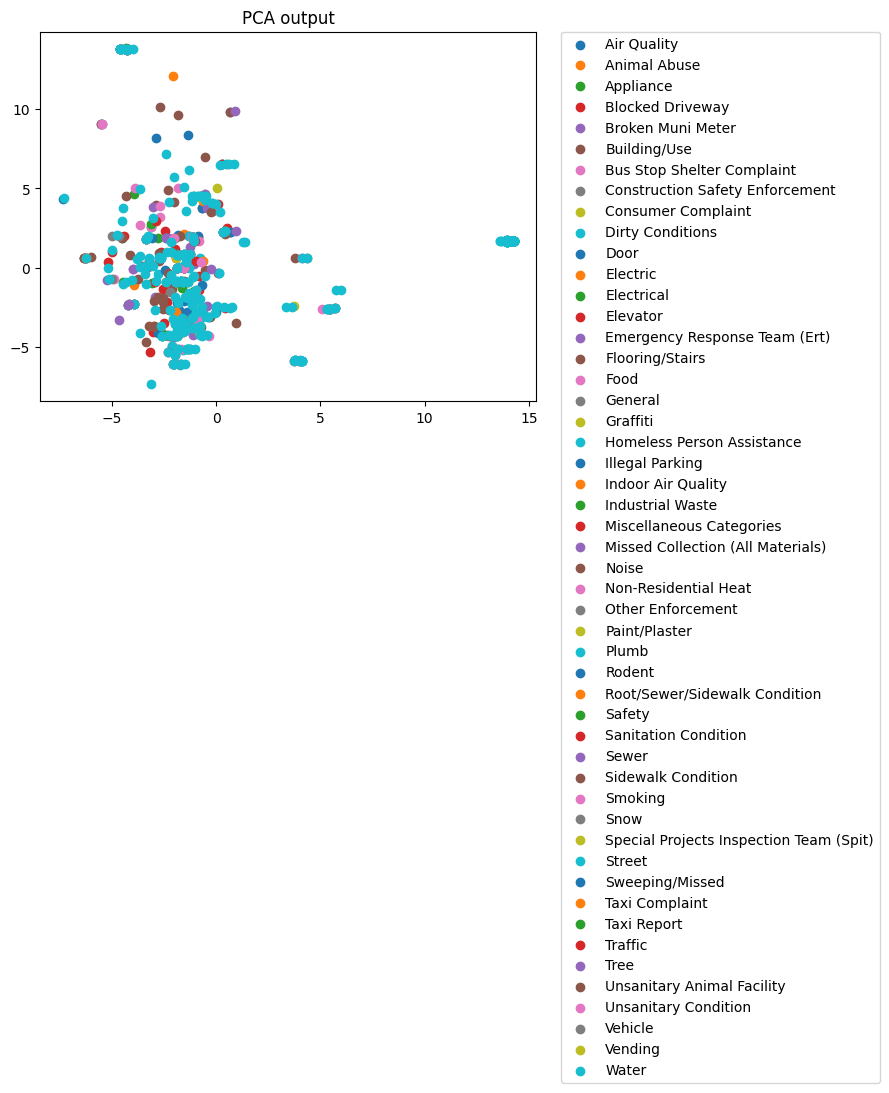

In [ ]:
# Create the t-SNE model
pca = PCA(n_components=2)
scaler = StandardScaler()

# Get the t-SNE coordinates
pca_feats = pd.DataFrame(np.vstack(data_311_clean['Descriptor Embdng'].values))

pca_feats[['IsDayHour_Day', 'IsDayHour_Night',
       'IsWeekend_Weekday', 'IsWeekend_Weekend', 'IsWinter_Summer',
       'IsWinter_Winter', 'Agency_DEP', 'Agency_DOB', 'Agency_DOT',
       'Agency_DSNY', 'Agency_HPD', 'Agency_NYPD', 'Agency_OTHER']] = data_311_clean[['IsDayHour_Day', 'IsDayHour_Night',
       'IsWeekend_Weekday', 'IsWeekend_Weekend', 'IsWinter_Summer',
       'IsWinter_Winter', 'Agency_DEP', 'Agency_DOB', 'Agency_DOT',
       'Agency_DSNY', 'Agency_HPD', 'Agency_NYPD', 'Agency_OTHER']].values


pca_feats['Complaint Type'] = data_311_clean['Complaint Type'].values

# sampling
stratified_pca_feats = pca_feats.groupby('Complaint Type').apply(lambda x: x.sample(frac=0.01)).droplevel(0)

# Transform the input data using the StandardScaler object.
stratified_pca_feats.columns = stratified_pca_feats.columns.astype(str)
stratified_pca_feats_stand = scaler.fit_transform(stratified_pca_feats.drop('Complaint Type', axis=1))
pca_coords = pca.fit_transform(stratified_pca_feats_stand)
# Plot the data
plt.figure(figcnt, figsize=(16,16))
fig, ax = plt.subplots()
groups = pd.DataFrame(pca_coords, columns=['coord1', 'coord2']).assign(category=stratified_pca_feats['Complaint Type']).groupby('category')
for name, points in groups:
  ax.scatter(points.coord1, points.coord2, label=name)
ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title('PCA output')
figcnt += 1

In [ ]:
pca = PCA(n_components=30)
scaler = StandardScaler()

# Get the t-SNE coordinates
pca_feats = pd.DataFrame(np.vstack(data_311_clean['Descriptor Embdng'].values))

pca_feats[['IsDayHour_Day', 'IsDayHour_Night',
       'IsWeekend_Weekday', 'IsWeekend_Weekend', 'IsWinter_Summer',
       'IsWinter_Winter', 'Agency_DEP', 'Agency_DOB', 'Agency_DOT',
       'Agency_DSNY', 'Agency_HPD', 'Agency_NYPD', 'Agency_OTHER','X Coordinate (State Plane)', 'Y Coordinate (State Plane)','Duration']] = data_311_clean[['IsDayHour_Day', 'IsDayHour_Night',
       'IsWeekend_Weekday', 'IsWeekend_Weekend', 'IsWinter_Summer',
       'IsWinter_Winter', 'Agency_DEP', 'Agency_DOB', 'Agency_DOT',
       'Agency_DSNY', 'Agency_HPD', 'Agency_NYPD', 'Agency_OTHER','X Coordinate (State Plane)', 'Y Coordinate (State Plane)','Duration']].values


pca_feats['Complaint Type'] = data_311_clean['Complaint Type'].values

# sampling
stratified_pca_feats = pca_feats.groupby('Complaint Type').apply(lambda x: x.sample(frac=0.1)).droplevel(0)

# Transform the input data using the StandardScaler object.
stratified_pca_feats.columns = stratified_pca_feats.columns.astype(str)
stratified_pca_feats_stand = scaler.fit_transform(stratified_pca_feats.drop('Complaint Type', axis=1))
pca_coords = pca.fit_transform(stratified_pca_feats_stand)

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

array([0.12017632, 0.20312505, 0.26744508, 0.31643107, 0.35985643,
       0.3966248 , 0.42981269, 0.45549908, 0.47998879, 0.50373799,
       0.52571325, 0.54608928, 0.56501624, 0.58192483, 0.59848554,
       0.61422148, 0.62817618, 0.64182484, 0.65399616, 0.66601748,
       0.67725212, 0.6883927 , 0.6988408 , 0.70859387, 0.71798696,
       0.72712797, 0.73561022, 0.74404187, 0.75194837, 0.75948558])

In [ ]:
cluster_input = pd.DataFrame(pca_coords)
cluster_input['Complaint Type'] = stratified_pca_feats['Complaint Type'].values

In [ ]:
cluster_input = cluster_input.groupby('Complaint Type').median()

In [ ]:
import scipy.cluster.hierarchy as hcluster
from scipy.spatial.distance import pdist

In [ ]:
distances = pdist(cluster_input)

In [ ]:
linkage = hcluster.linkage(distances, method='ward')

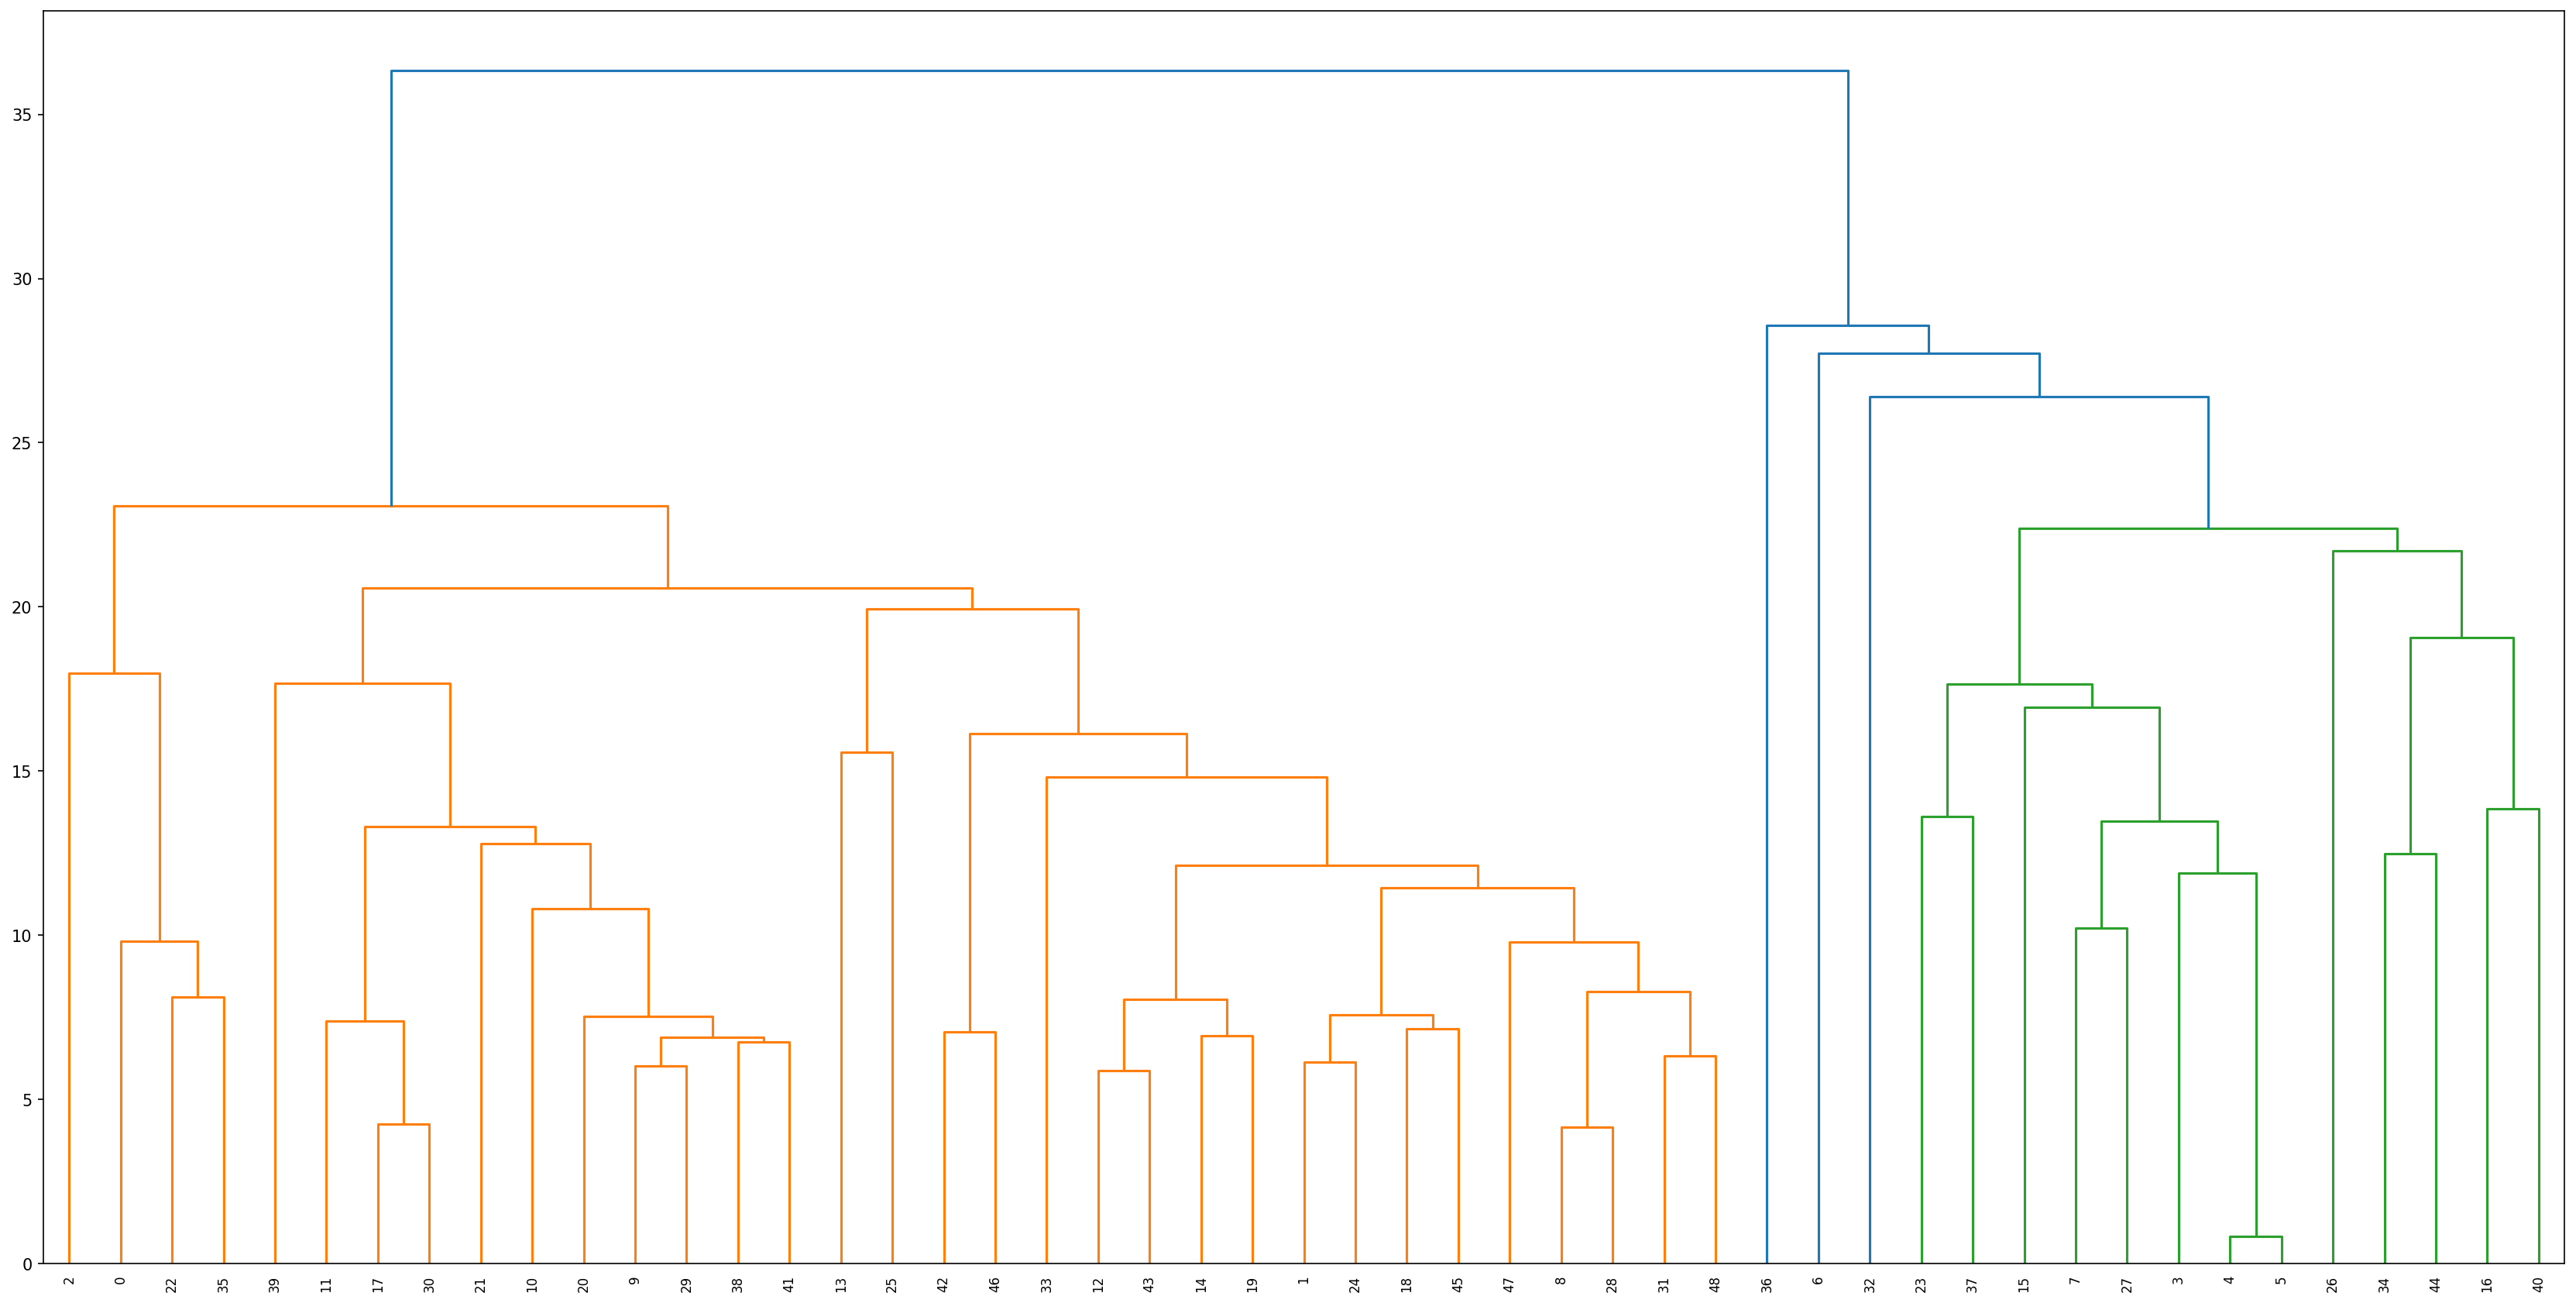

In [ ]:
plt.figure(figsize=(28,14),dpi=150)
hcluster.dendrogram(linkage)
plt.show()

In [ ]:
# add a new column to data_311_clean based on the Complaint Type
data_311_clean['Cluster'] = np.nan
data_311_clean.loc[data_311_clean['Complaint Type'].isin(c1) , 'Cluster'] = 1
data_311_clean.loc[data_311_clean['Complaint Type'].isin(c2) , 'Cluster'] = 2
data_311_clean.loc[data_311_clean['Complaint Type'].isin(c3) , 'Cluster'] = 3
data_311_clean.loc[data_311_clean['Complaint Type'].isin(c4) , 'Cluster'] = 4
data_311_clean.loc[data_311_clean['Complaint Type'].isin(c5) , 'Cluster'] = 5

## clean the weather data and get ready to merge it to 311 call

In [ ]:
# prompt: use Year Month Day columns to create a new data column in the format of Timestamp 'Y-m-d'
data_weather_in['Created Date'] = pd.to_datetime(data_weather_in[['Year', 'Month', 'Day']])
data_weather_in.sort_values(by='Created Date', inplace=True)

<Axes: title={'center': 'StationName %'}>

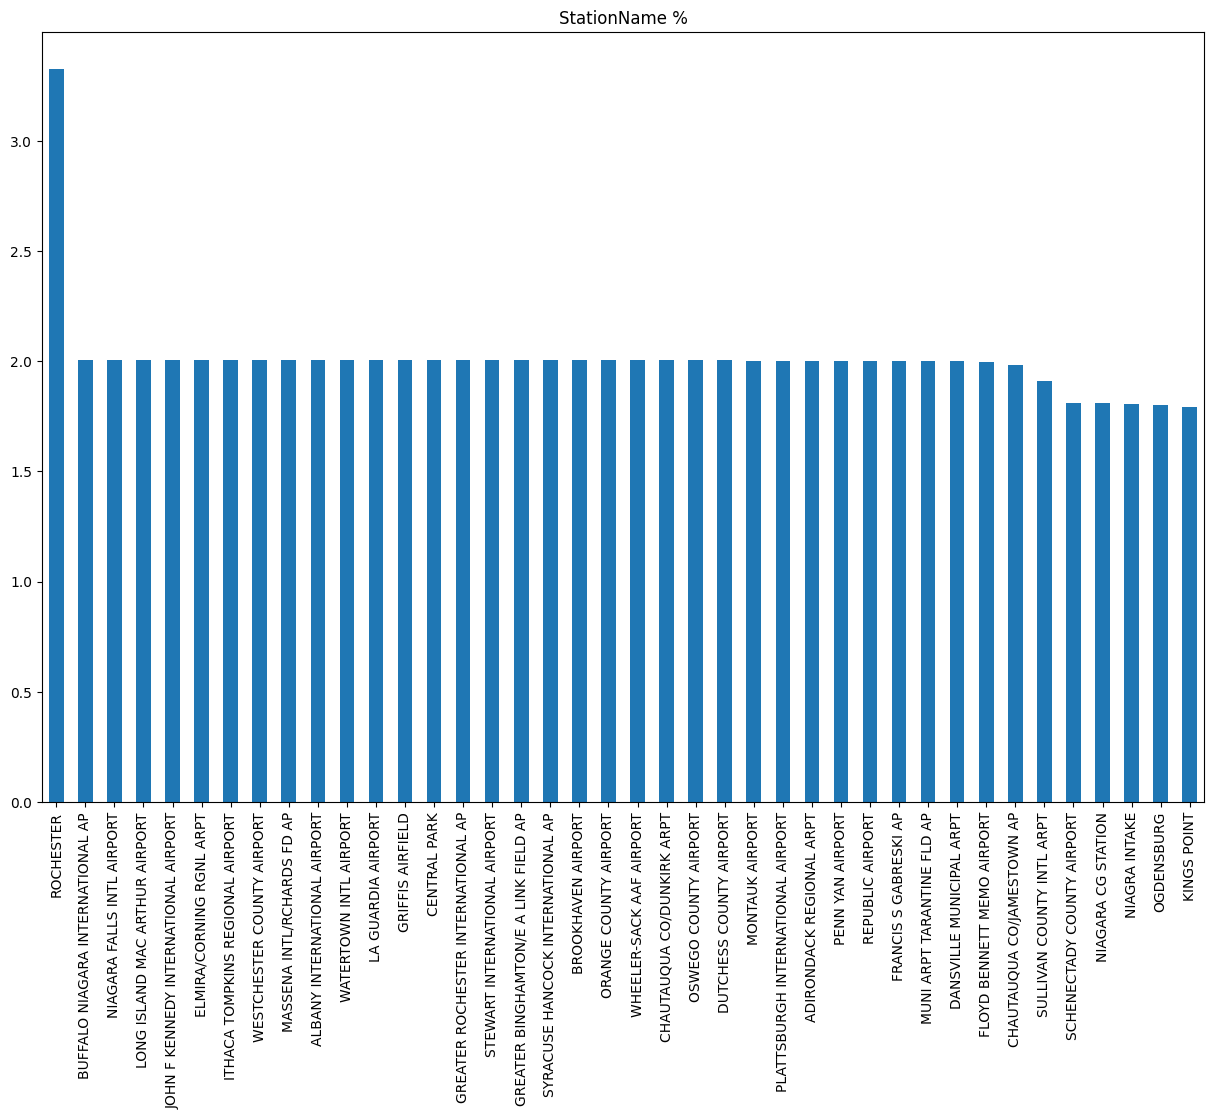

In [ ]:
(data_weather_in['StationName'].value_counts(normalize=True)*100).head(40).plot(kind='bar',title='StationName %', figsize=(15,10))

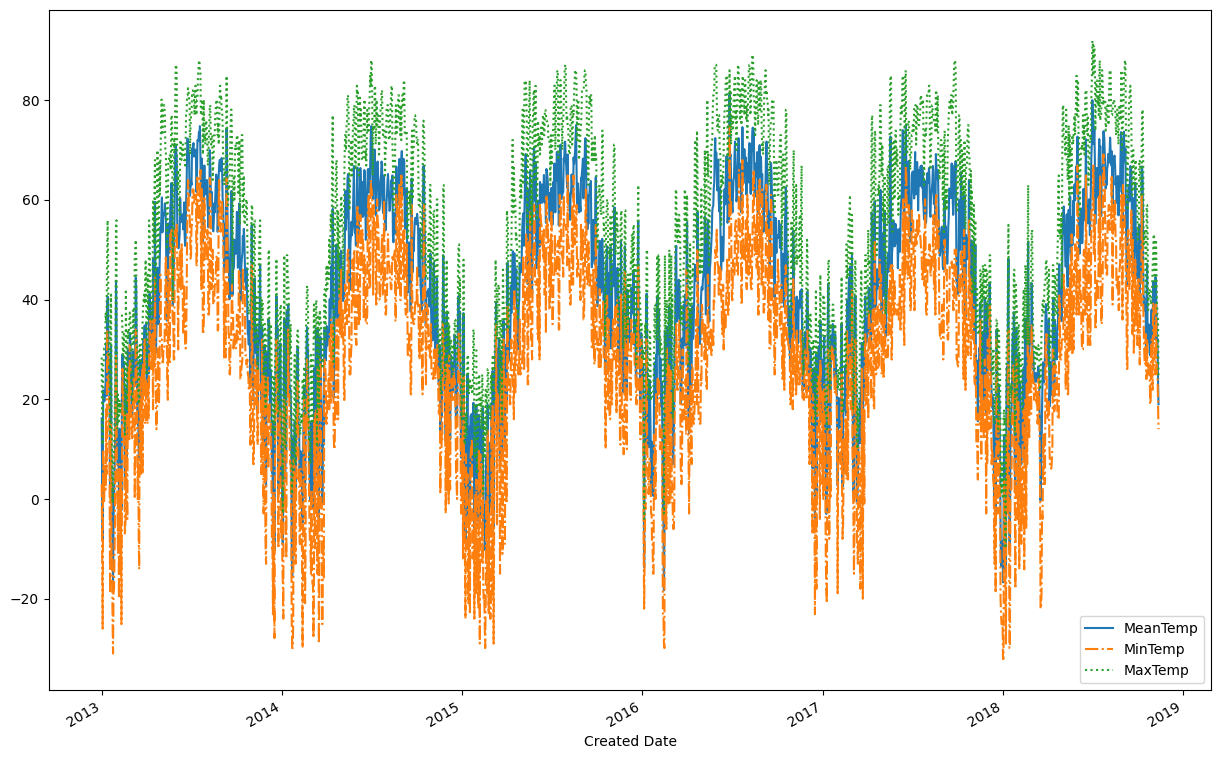

In [ ]:
data_weather_in[data_weather_in['StationName'].isin(['ADIRONDACK REGIONAL ARPT'])].groupby('StationName').plot(x='Created Date', y=['MeanTemp', 'MinTemp', 'MaxTemp'], style=['-', '-.', ':'], figsize=(15,10))
plt.show()

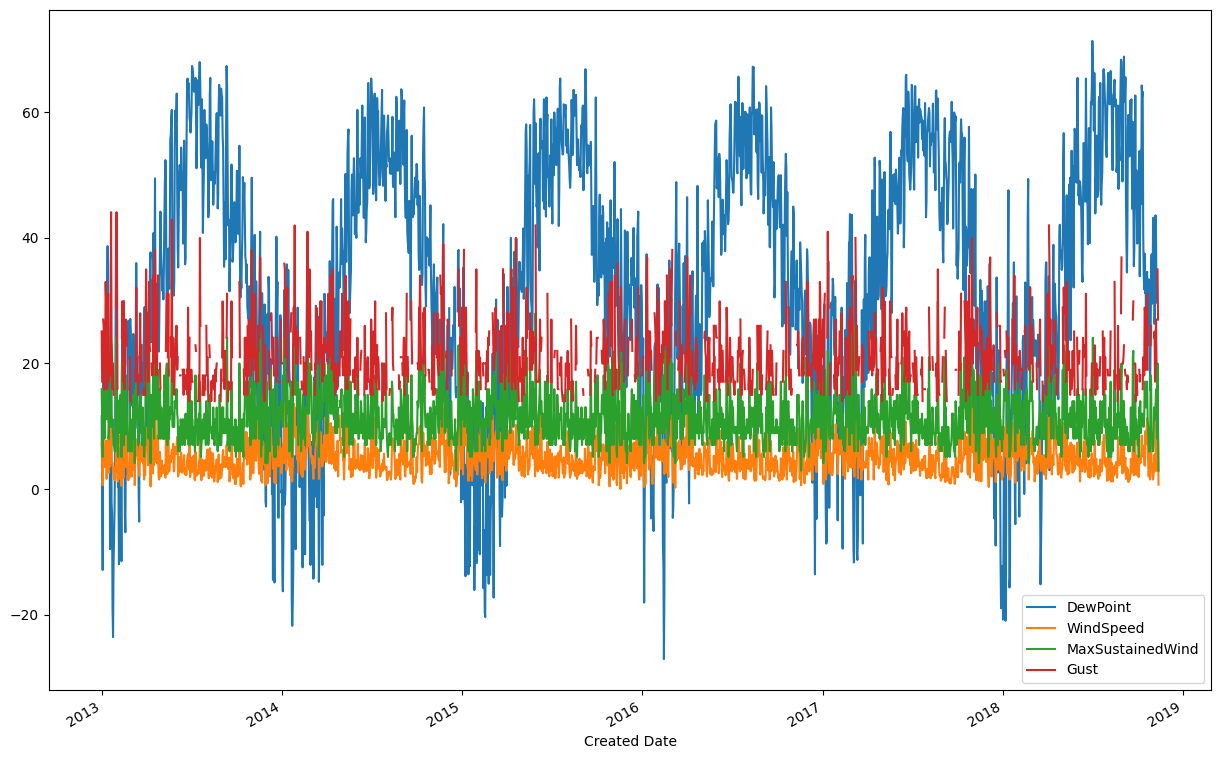

In [ ]:
data_weather_in[data_weather_in['StationName'].isin(['ADIRONDACK REGIONAL ARPT'])].groupby('StationName').plot(x='Created Date', y=['DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust'], figsize=(15,10))
plt.show()


<ipython-input-195-4ecaefd0a5c8>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_weather_in.groupby(['Created Date']).mean()[['Percipitation']].plot(title='Average Daily Percipitation', figsize=(15,10))


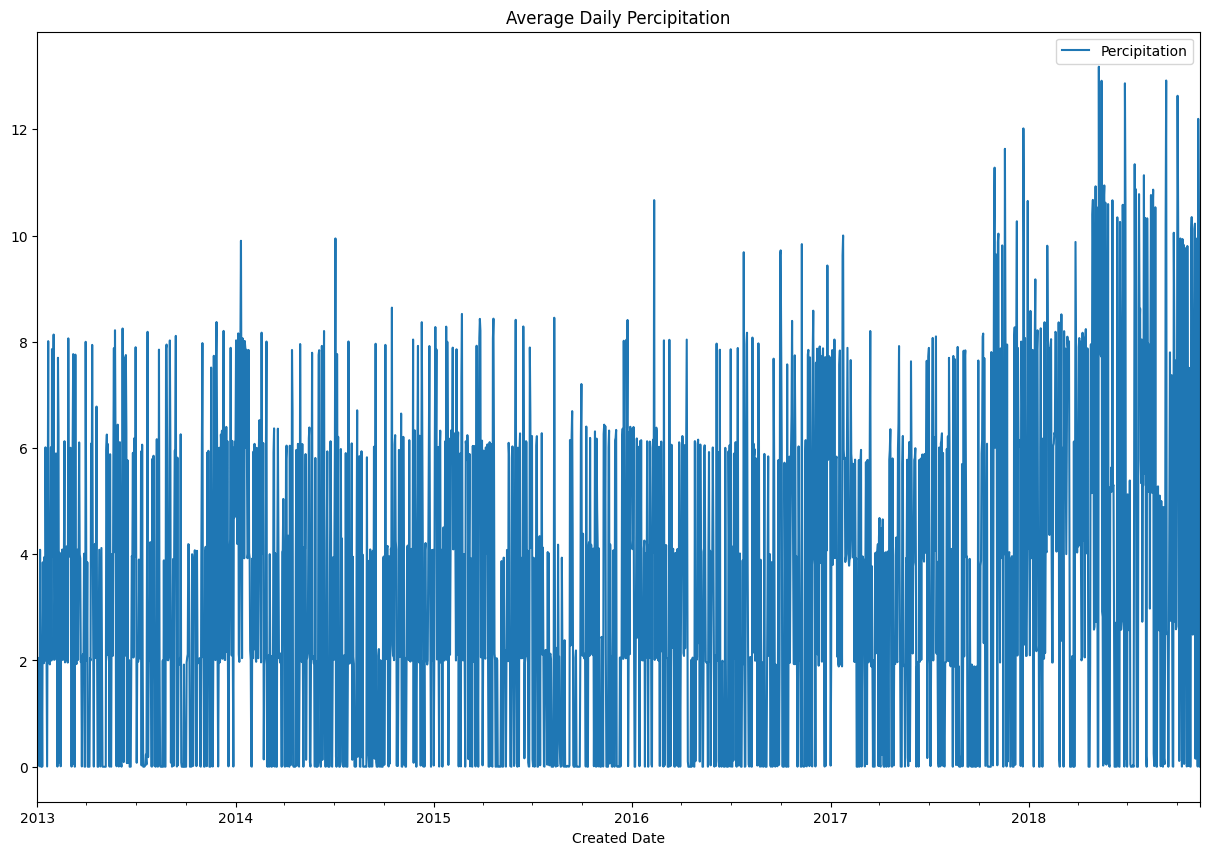

In [ ]:
data_weather_in.groupby(['Created Date']).mean()[['Percipitation']].plot(title='Average Daily Percipitation', figsize=(15,10))
plt.show()

<ipython-input-196-2be67c917030>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_weather_in.groupby(['Created Date']).mean()[['SnowDepth']].plot(title='Average Daily SnowDepth', figsize=(15,10))


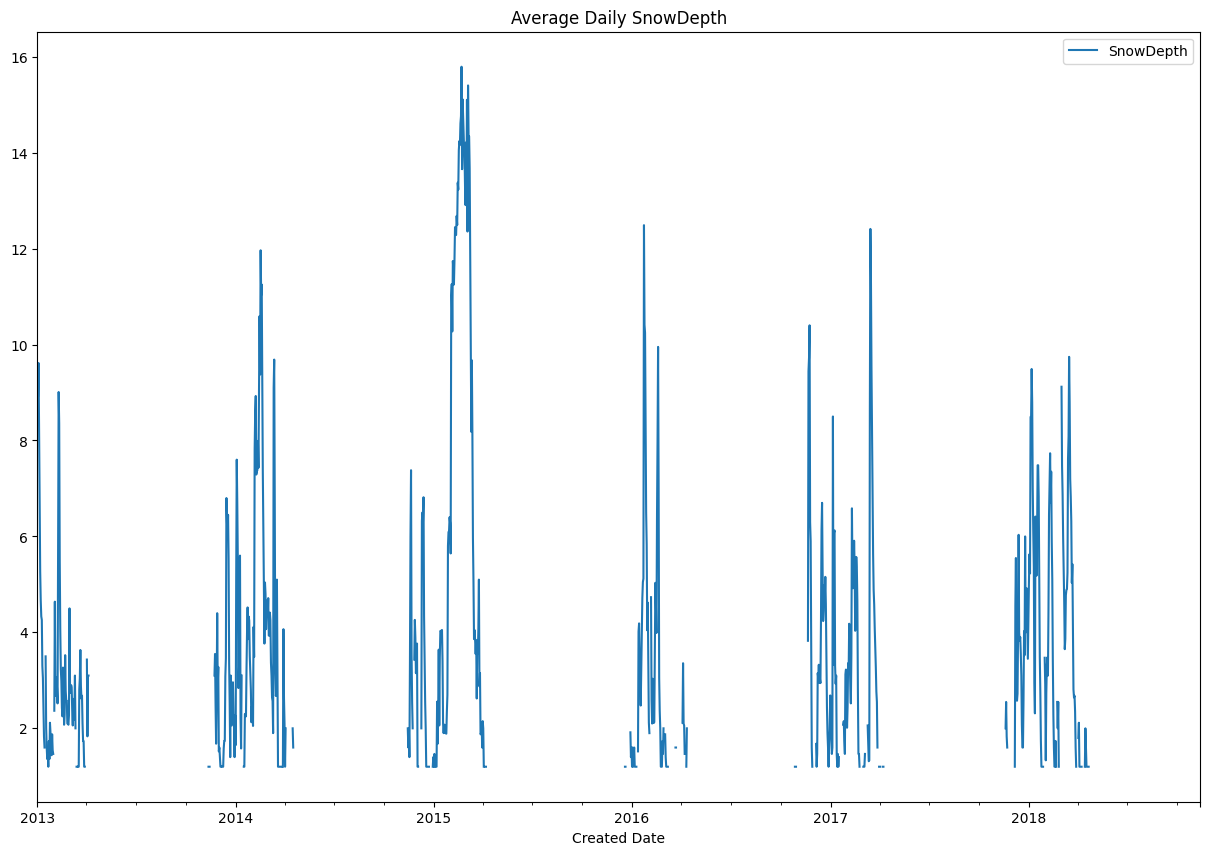

In [ ]:
data_weather_in.groupby(['Created Date']).mean()[['SnowDepth']].plot(title='Average Daily SnowDepth', figsize=(15,10))
plt.show()

In [ ]:
data_weather_in = data_weather_in[data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation']].apply(lambda x: (x - x.mean(axis=0)<-2.5*x.std(axis=0)) | (x - x.mean(axis=0)>2.5*x.std(axis=0))).sum(axis=1)<=3]

In [ ]:
# fill missing value for 'MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation' using the average groupby StationName and Month
data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation']] = data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation']].fillna(data_weather_in.groupby(['StationName', 'Month']).transform('mean') )

<ipython-input-248-89051d096f57>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation']] = data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation']].fillna(data_weather_in.groupby(['StationName', 'Month']).transform('mean') )
<ipython-input-248-89051d096f57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxS

In [ ]:
# using forward and backward fill groupby StationName, for columns 'MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation'
data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation']] = data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation','StationName']].groupby(['StationName']).transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

<ipython-input-249-9263f5c08854>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation']] = data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation','StationName']].groupby(['StationName']).transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [ ]:
# using forward and backward fill groupby Month, for columns 'MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation'
data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation']] = data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation','Month']].groupby(['Month']).transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

<ipython-input-250-37198775596c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation']] = data_weather_in[['MeanTemp', 'MinTemp', 'MaxTemp','DewPoint', 'WindSpeed', 'MaxSustainedWind', 'Gust','Percipitation','Month']].groupby(['Month']).transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


## do similar first step filling for SnowDepth, but we zero fill in the remaining

In [ ]:
data_weather_in[['SnowDepth']] = data_weather_in[['SnowDepth']].fillna(data_weather_in.groupby(['StationName', 'Month']).transform('mean') )
data_weather_in[['SnowDepth']] = data_weather_in[['SnowDepth']].fillna(0.0)

<ipython-input-252-292c6506b0a6>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_weather_in[['SnowDepth']] = data_weather_in[['SnowDepth']].fillna(data_weather_in.groupby(['StationName', 'Month']).transform('mean') )
<ipython-input-252-292c6506b0a6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weather_in[['SnowDepth']] = data_weather_in[['SnowDepth']].fillna(data_weather_in.groupby(['StationName', 'Month']).transform('mean') )
<ipython-input-252-292c6506b0a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [ ]:
data_weather_in = data_weather_in.loc[(data_weather_in['Year']>=2013)&(data_weather_in['Year']<=2018)]

In [ ]:
tmp_station_rank = pd.merge(data_weather_in.groupby(['StationName'])['Rain'].sum().sort_values(ascending=False).to_frame() / data_weather_in[data_weather_in.Rain==1].shape[0] , data_weather_in.groupby(['StationName'])['SnowIce'].sum().sort_values(ascending=False).to_frame() / data_weather_in[data_weather_in.SnowIce==1].shape[0] , how='inner' , left_index=True, right_index=True)

In [ ]:
data_weather_clean = data_weather_in[['StationName', 'State', 'Latitude', 'Longitude',
       'MeanTemp', 'MinTemp', 'MaxTemp', 'DewPoint', 'Percipitation',
       'WindSpeed', 'MaxSustainedWind', 'Gust', 'Rain', 'SnowDepth', 'SnowIce',
       'Year', 'Month', 'Day', 'Created Date']]

In [ ]:
data_311_clean = data_311_clean[['Created Date','Complaint Type','Community Board', 'Borough','Latitude', 'Longitude', 'Duration','day', 'month', 'weekday', 'hour', 'year','IsDayHour_Day', 'IsDayHour_Night',
       'IsWeekend_Weekday', 'IsWeekend_Weekend', 'IsWinter_Summer',
       'IsWinter_Winter','Cluster']]

In [ ]:
data_311_clean['Created Date'] = pd.to_datetime(data_311_clean[['year', 'month', 'day']])

<ipython-input-297-fae0313d9e6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_311_clean['Created Date'] = pd.to_datetime(data_311_clean[['year', 'month', 'day']])


In [ ]:
data_weather_clean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pt72_MI/data_weather_clean.csv', index_col=0)
data_weather_clean['Created Date'] = pd.to_datetime(data_weather_clean[['Year', 'Month', 'Day']])

In [ ]:
weather_station_loc = data_weather_clean.groupby(['StationName'])[['Latitude','Longitude']].median()

In [ ]:
data_311_clean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pt72_MI/data_311_clean.csv', index_col=0)
data_311_clean['Created Date'] = pd.to_datetime(data_311_clean[['year', 'month', 'day']])

In [ ]:
cb_loc = data_311_clean.groupby(['Community Board'])[['Latitude','Longitude']].median()
cb_loc['5_nearest'] = cb_loc.apply(lambda x: (x['Latitude'] - weather_station_loc['Latitude'])**2 + (x['Longitude'] - weather_station_loc['Longitude'])**2 , axis=1).apply(lambda x: x.sort_values()[:5].index.to_list(), axis=1)

In [ ]:
cb_loc = cb_loc['5_nearest'].to_dict()

In [ ]:
data_weather_nearest = data_311_clean.groupby(['Created Date','Community Board']).apply(lambda x: data_weather_clean.loc[(data_weather_clean['Created Date']==x['Created Date'].iloc[0]) & (data_weather_clean['StationName'].isin(cb_loc[x['Community Board'].iloc[0]])) ,\
                                                                                          ['MeanTemp','MinTemp','MaxTemp','DewPoint','Percipitation','WindSpeed','MaxSustainedWind','Gust','Rain','SnowDepth','SnowIce']].mean(axis=0, skipna=True) )

In [ ]:
data_311_weather = data_311_clean.merge(data_weather_nearest.reset_index() , how='left', on=['Created Date','Community Board'])

In [ ]:
data_311_weather.fillna(data_311_weather.groupby(['Borough', 'month']).transform('mean'), inplace=True)

<ipython-input-12-8443f61194f7>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_311_weather.fillna(data_311_weather.groupby(['Borough', 'month']).transform('mean'), inplace=True)


In [ ]:
data_311_weather['SnowIce'] = data_311_weather['SnowIce'].apply(lambda x: 1 if x>=0.5 else 0)
data_311_weather['Rain'] = data_311_weather['Rain'].apply(lambda x: 1 if x>=0.5 else 0)

In [ ]:
heatmap_df = data_311_weather.groupby(['Community Board', 'IsWinter_Winter'])['Longitude','Latitude','MeanTemp','DewPoint','WindSpeed','SnowDepth'].mean().reset_index()

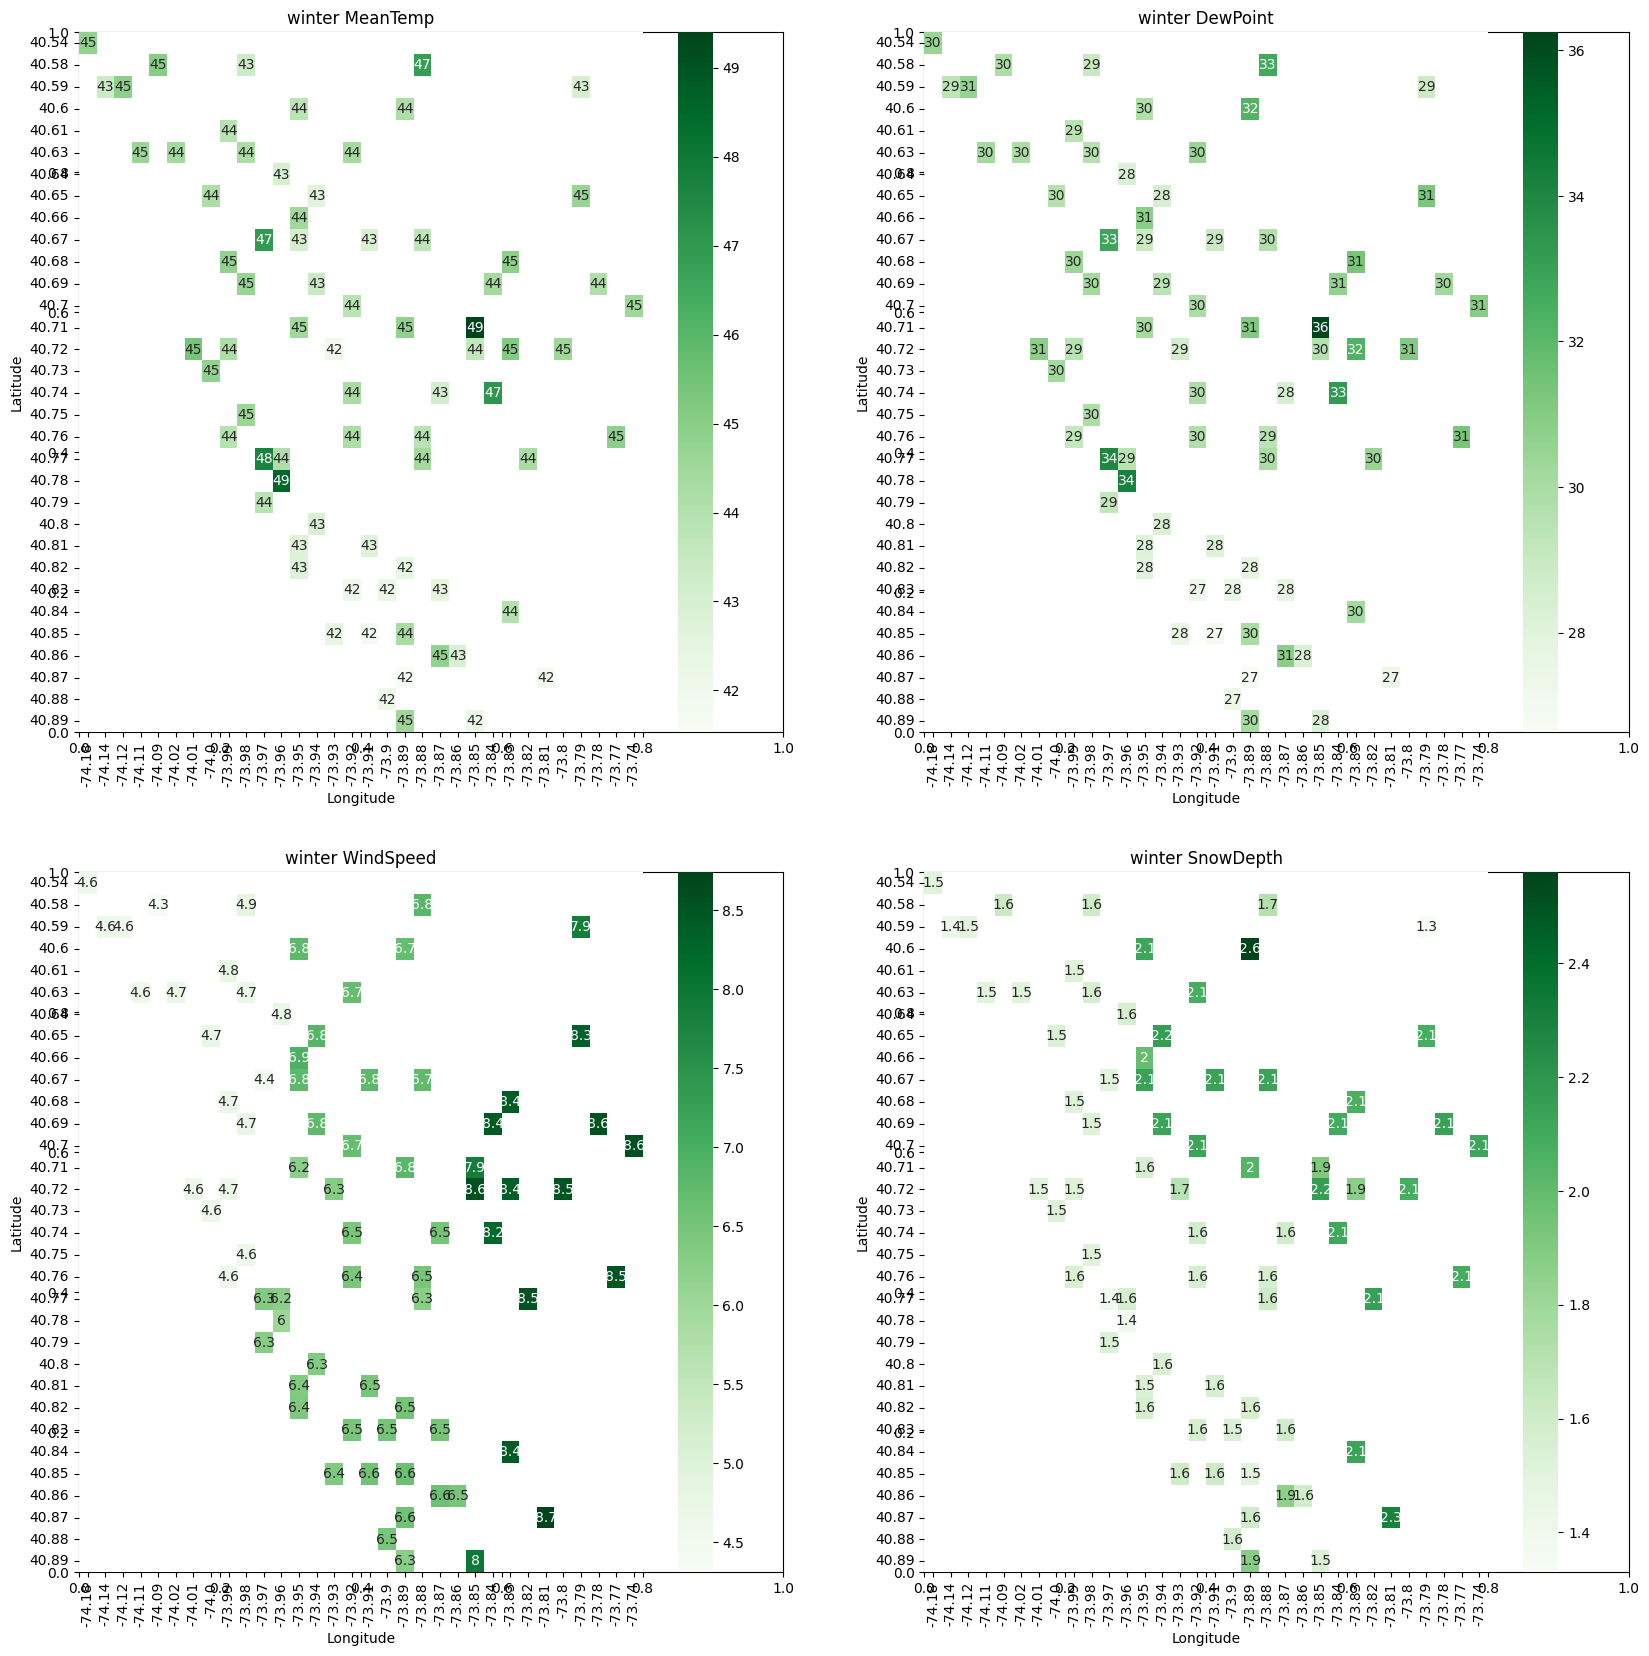

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
i=1
for col in heatmap_df.columns[-4:]:
  ax = fig.add_subplot(2, 2, i)
  sns.heatmap( round(heatmap_df[heatmap_df.IsWinter_Winter==1],2).pivot_table(values=col, index='Latitude', columns='Longitude') , cmap='Greens', annot=True)
  ax.set_title('winter '+col)
  i+=1

In [ ]:
data_311_weather = data_311_weather[['Created Date', 'Complaint Type', 'Borough', 'Duration', 'day', 'month', 'weekday', 'hour',
       'year', 'IsDayHour_Day', 'IsWeekend_Weekend', 'IsWinter_Winter', 'Cluster',
       'MeanTemp', 'MinTemp', 'MaxTemp', 'DewPoint', 'Percipitation',
       'WindSpeed', 'MaxSustainedWind', 'Gust', 'Rain', 'SnowDepth',
       'SnowIce']]

data_311_weather['Up'] = data_311_weather['MaxTemp'] - data_311_weather['MeanTemp']
data_311_weather['Down'] = data_311_weather['MinTemp'] - data_311_weather['MeanTemp']

In [ ]:
data_311_weather.drop(['MinTemp', 'MaxTemp', 'MeanTemp'], axis=1, inplace=True)

In [ ]:
pca = PCA(n_components=2)
pca.fit(data_311_weather[['WindSpeed','MaxSustainedWind','Gust']])
data_311_weather[['wind_1','wind_2']] = pca.transform(data_311_weather[['WindSpeed','MaxSustainedWind','Gust']])

In [ ]:
data_311_weather.drop(['WindSpeed', 'MaxSustainedWind', 'Gust'], axis=1, inplace=True)

<Axes: >

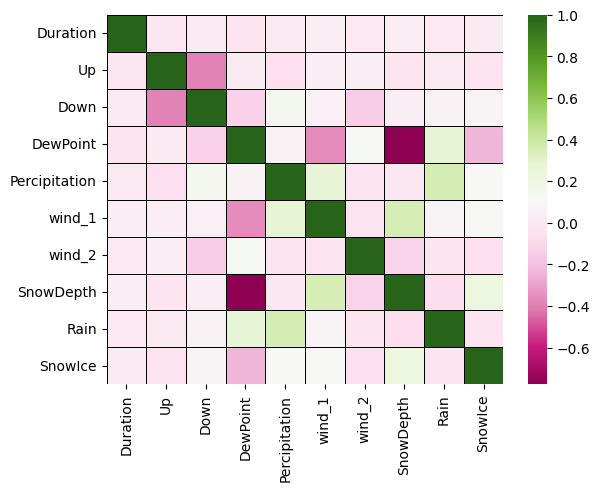

In [ ]:
import seaborn as sns
sns.heatmap(data_311_weather[['Duration','Up','Down','DewPoint','Percipitation','wind_1','wind_2','SnowDepth','Rain','SnowIce']].corr('spearman'), cmap='PiYG', linecolor='black', linewidths=0.5)

In [ ]:
data_311_weather_rf = data_311_weather.groupby(['Borough','Cluster','IsWinter_Winter','IsWeekend_Weekend']).apply(lambda x: x.sample(frac=0.01)).reset_index(drop=True)

In [ ]:


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_311_weather_rf[['IsWeekend_Weekend','IsWinter_Winter','Up','Down','DewPoint','Percipitation','wind_1','wind_2','SnowDepth','Rain','SnowIce']], data_311_weather_rf['Borough'], test_size=0.25)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.5660899653979239


<Axes: >

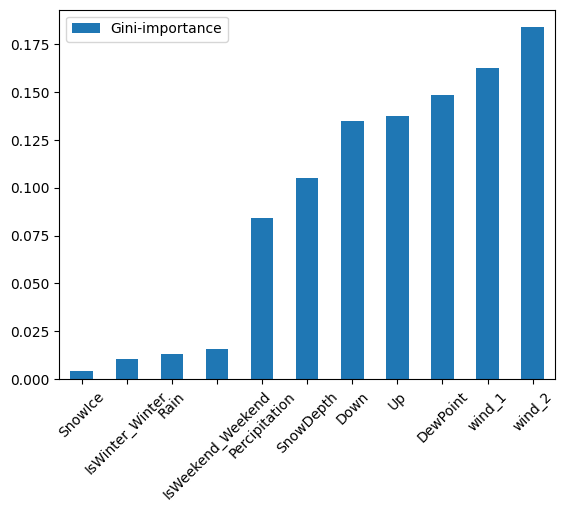

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(data_311_weather_rf[['IsWeekend_Weekend','IsWinter_Winter','Up','Down','DewPoint','Percipitation','wind_1','wind_2','SnowDepth','Rain','SnowIce']].columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

# 3. baseline model time series analysis solely focused on the 311 data

## we run 2 baseline models in this section: (1) aggregating all calls during a day and use time series analysis to predict the future 7-day value (2) groupby Complaint Cluster and run separate time series analysis, then add up the prediction

In [ ]:
baseline_data_1 = data_311_clean.groupby('Created Date').mean()[['IsDayHour_Day','IsWeekend_Weekend','IsWinter_Winter']]

In [ ]:
baseline_data_1['Volume'] = data_311_clean.groupby('Created Date').size().values

In [ ]:
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima

In [ ]:
# Prepare the fourier terms to add as exogenous features to auto_arima
four_terms = FourierFeaturizer(30, 1)
y_prime, exog = four_terms.fit_transform(baseline_data_1['Volume'])

In [ ]:
baseline_data_1['Volume_pred'] = np.nan

In [ ]:
for train_end_idx in range(850, 900 ,7): #len(y_prime)-7,
  y_prime_train = y_prime.iloc[train_end_idx-820:train_end_idx]
  exog_train = exog.iloc[train_end_idx-820:train_end_idx]

  y_prime_test = y_prime.iloc[train_end_idx:train_end_idx+7]
  exog_test = exog.iloc[train_end_idx:train_end_idx+7]

  # Fit model
  # Weekly seasonality covered by SARIMAX
  arima_exog_model = auto_arima(y=y_prime_train, start_p=1, start_q=0,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=1, max_q=0, # maximum p and q
                      exogenous=exog_train, seasonal=True, m=7, stepwise=False,
                      start_P=2, max_P=2, D=0, error_action='ignore', trace=False, n_fits=5, random=True, verbose=True)

  try:
    # Forecast
    y_arima_exog_forecast = arima_exog_model.predict(n_periods=len(exog_test), exogenous=exog_test.fillna(exog_test.mean()))
  except:
    continue

  # store
  baseline_data_1.loc[y_arima_exog_forecast.index , 'Volume_pred'] = y_arima_exog_forecast.values

<Axes: xlabel='Created Date'>

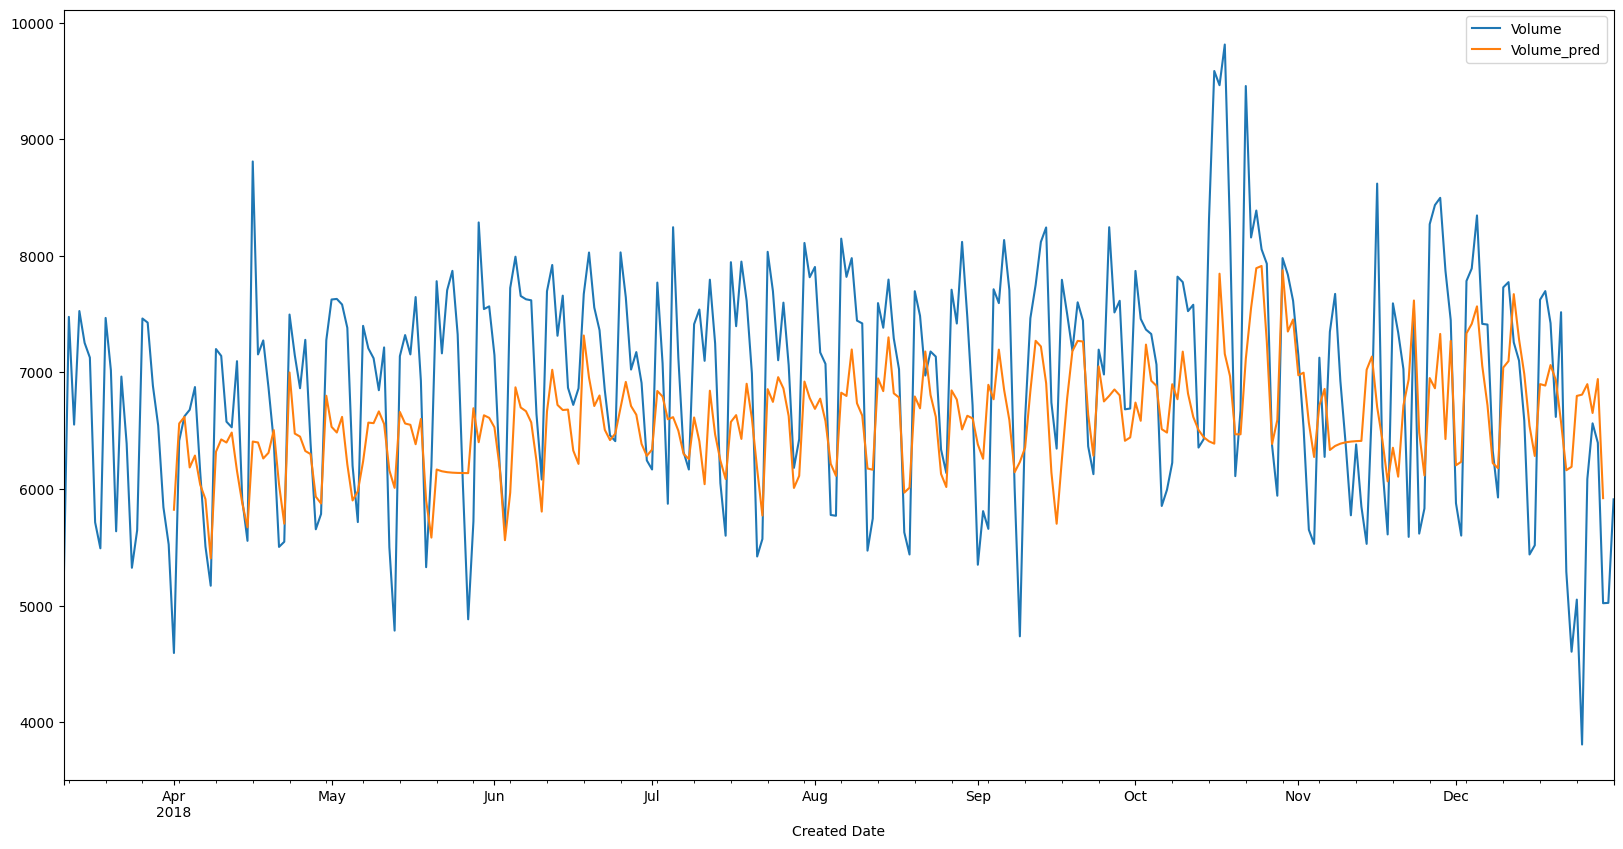

In [ ]:
baseline_data_1[['Volume','Volume_pred']].iloc[800:].plot(figsize=(20,10))

In [ ]:
baseline_data_2 = data_311_clean.groupby(['Created Date','Cluster']).size().reset_index()

In [ ]:
baseline_data_2.columns = ['Created Date','Cluster','Volume']

In [ ]:
baseline_data_2.set_index('Created Date', inplace=True)

In [ ]:
baseline_data_2 = baseline_data_2.pivot_table(index='Created Date', columns='Cluster', values='Volume').fillna(0.0)

In [ ]:
for c in range(1,6):
  baseline_data_2[str(c)+'_pred'] = np.nan

In [ ]:
for c in range(1,6):

  # Prepare the fourier terms to add as exogenous features to auto_arima
  four_terms = FourierFeaturizer(30, 1)
  y_prime, exog = four_terms.fit_transform(baseline_data_2[c])

  print('running for cluster ', c)
  for train_end_idx in range(900, len(y_prime)-15, 7): #
    y_prime_train = y_prime.iloc[train_end_idx-845:train_end_idx]
    exog_train = exog.iloc[train_end_idx-845:train_end_idx]

    y_prime_test = y_prime.iloc[train_end_idx:train_end_idx+7]
    exog_test = exog.iloc[train_end_idx:train_end_idx+7]

    # Fit model
    # Weekly seasonality covered by SARIMAX
    arima_exog_model = auto_arima(y=y_prime_train, start_p=1, start_q=0,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=1, max_q=0, # maximum p and q
                      exogenous=exog_train, seasonal=True, m=7, stepwise=False,
                      start_P=2, max_P=2, D=0, error_action='ignore', trace=False, n_fits=5, random=True)

    try:
      # Forecast
      y_arima_exog_forecast = arima_exog_model.predict(n_periods=len(exog_test), exogenous=exog_test.fillna(exog_test.mean()))
    except:
      continue

    # store
    baseline_data_2.loc[y_arima_exog_forecast.index , str(c)+'_pred'] = y_arima_exog_forecast.values

running for cluster  1
running for cluster  2
running for cluster  3
running for cluster  4
running for cluster  5


<Axes: xlabel='Created Date'>

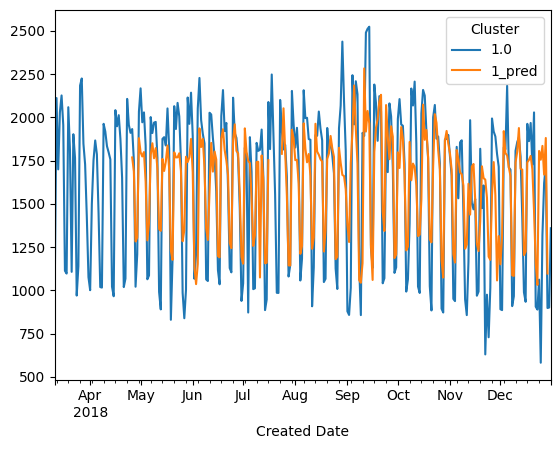

In [ ]:
baseline_data_2[[1.0,'1_pred']].iloc[800:].plot()

<Axes: xlabel='Created Date'>

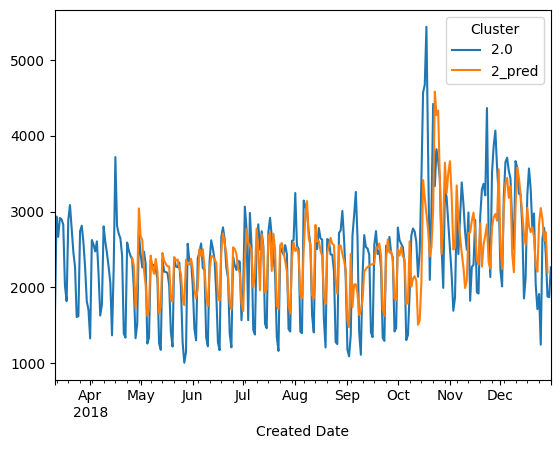

In [ ]:
baseline_data_2[[2.0,'2_pred']].iloc[800:].plot()

<Axes: xlabel='Created Date'>

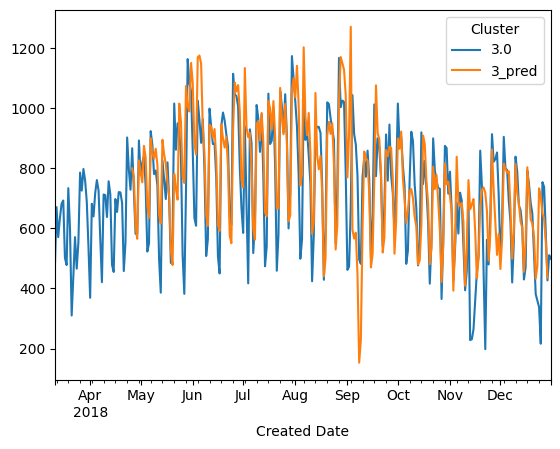

In [ ]:
baseline_data_2[[3.0,'3_pred']].iloc[800:].plot()

<Axes: xlabel='Created Date'>

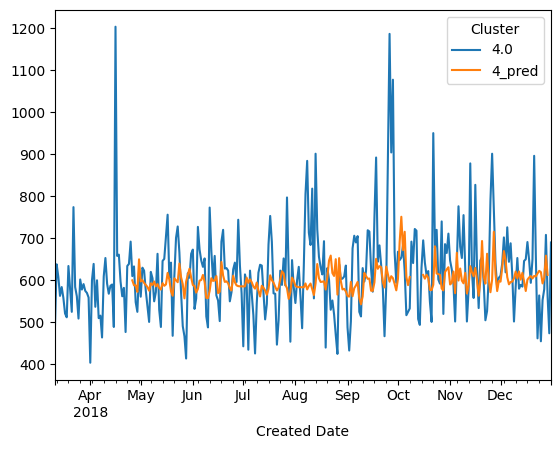

In [ ]:
baseline_data_2[[4.0,'4_pred']].iloc[800:].plot()

<Axes: xlabel='Created Date'>

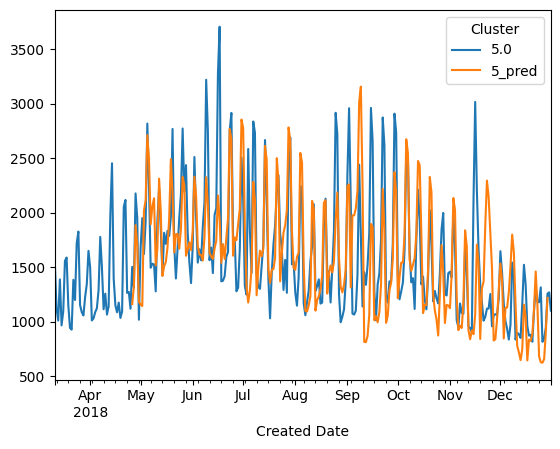

In [ ]:
baseline_data_2[[5.0,'5_pred']].iloc[800:].plot()

In [ ]:
baseline_2_data = baseline_2_data.iloc[:-2].fillna(method='ffill')

In [ ]:
baseline_agg_out = pd.concat([baseline_2_data.iloc[:,:5].sum(axis=1, skipna=False).rename('Volume') , baseline_2_data.iloc[:,5:].sum(axis=1, skipna=False).rename('Volume_pred_base2') ] , axis=1)

<Axes: xlabel='Created Date'>

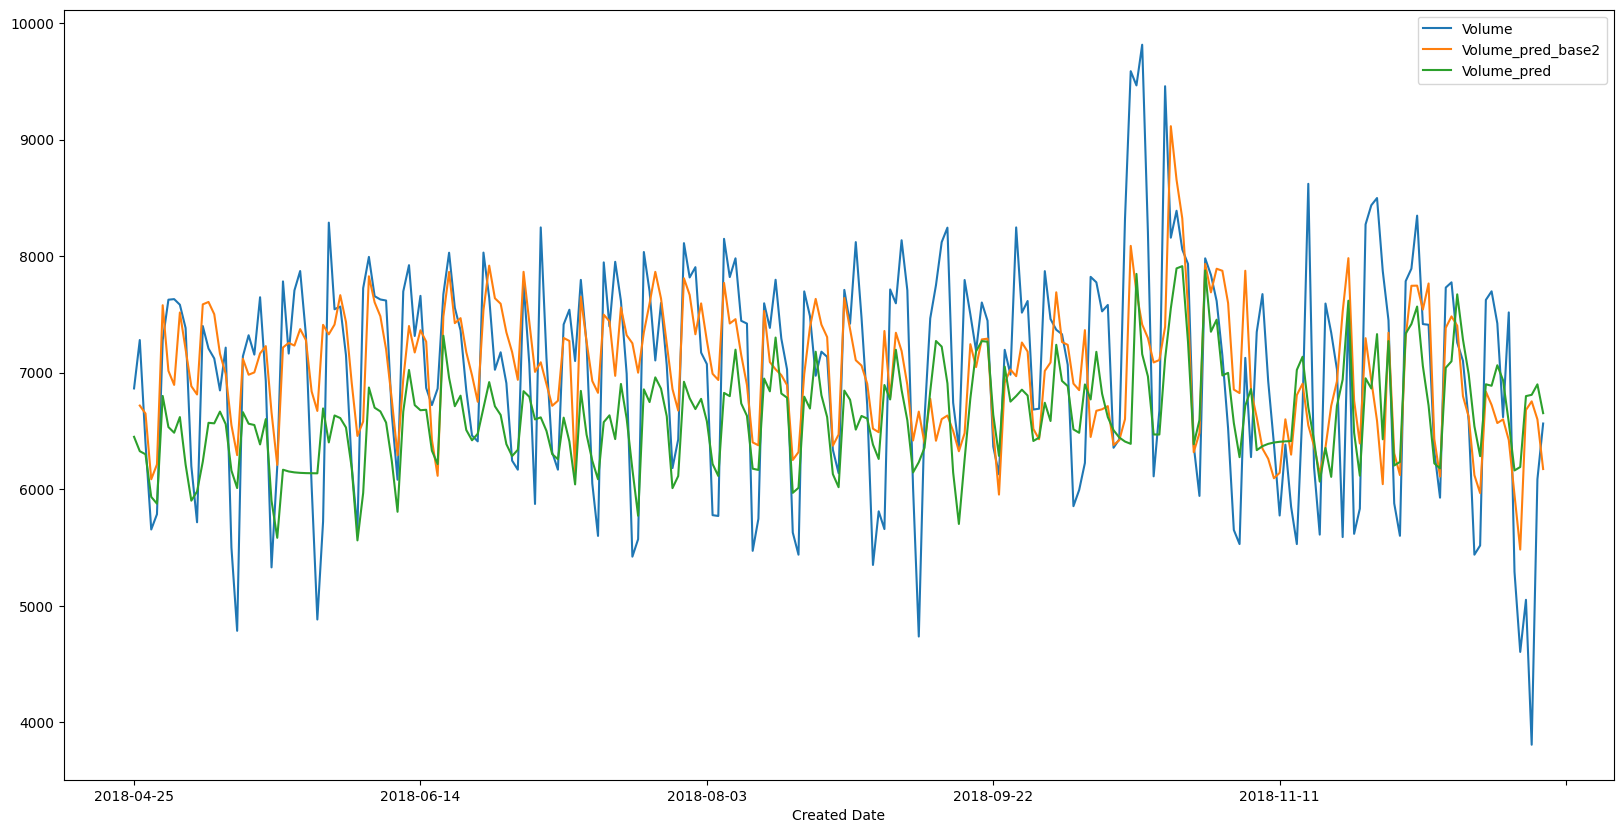

In [ ]:
baseline_agg_out = baseline_agg_out.merge(baseline_data_1.iloc[:,-1:], how='left', left_index=True, right_index=True)
baseline_agg_out.iloc[845:].plot(figsize=(20,10))

In [ ]:
baseline_agg_out['mse loss'] = ((baseline_agg_out['Volume']-baseline_agg_out['Volume_pred'])**2).rolling(7).mean()

In [ ]:
baseline_agg_out['mse loss_base2'] = ((baseline_agg_out['Volume']-baseline_agg_out['Volume_pred_base2'])**2).rolling(7).mean()

<Axes: xlabel='Created Date'>

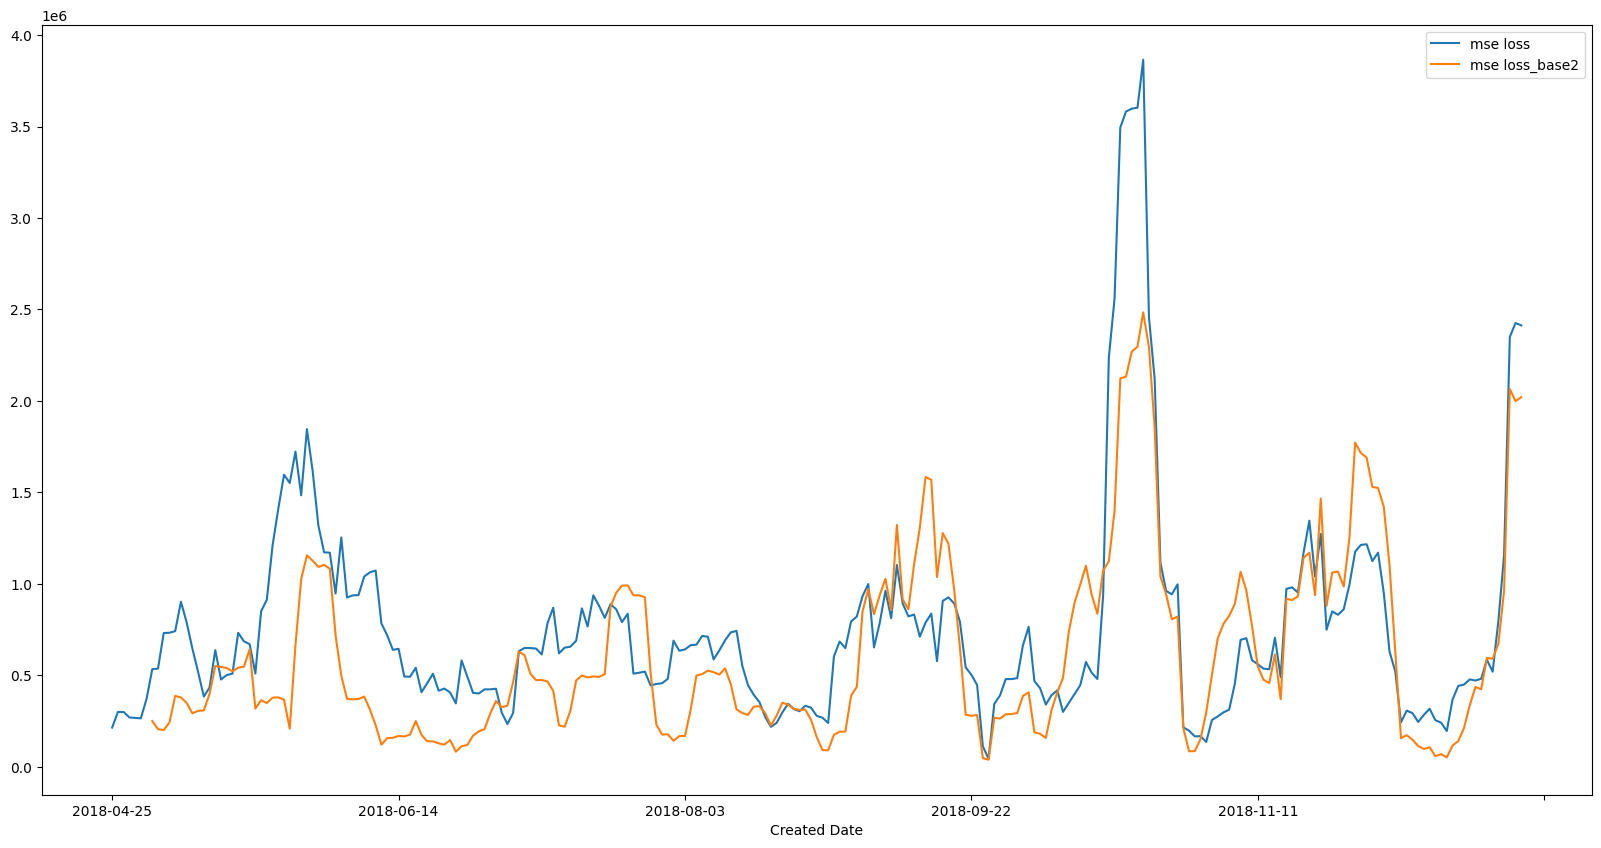

In [ ]:
baseline_agg_out[['mse loss','mse loss_base2']].iloc[845:].plot(figsize=(20,10))

# 4. linear predictive models (PLS) and nonlinear family (LSTM) when adding the weather data

In [ ]:
my_model_data = data_311_weather.groupby(['Created Date','Borough']).size().reset_index() # follow borough group

In [ ]:
my_model_data.columns = ['Created Date','Borough','Volume']

In [ ]:
# flatten the my_model_data so that Borough values are new columns
my_model_data = my_model_data.pivot_table(index='Created Date', columns='Borough', values='Volume').fillna(0.0)

In [ ]:
my_model_data['volume_tot'] = my_model_data.sum(axis=1)

In [ ]:
tmp_df = data_311_weather.groupby(['Created Date','Cluster']).size().reset_index() # follow cluster group
tmp_df.columns = ['Created Date','Cluster','Volume']
tmp_df = tmp_df.pivot_table(index='Created Date', columns='Cluster', values='Volume').fillna(0.0)

In [ ]:
my_model_data=my_model_data.merge(tmp_df, how='left', left_index=True, right_index=True)

In [ ]:
tmp_df = data_311_weather[['Created Date','Rain','SnowIce']].groupby(['Created Date']).mean().reset_index()

tmp_df['SnowIce'] = tmp_df['SnowIce'].apply(lambda x: 1 if x>=0.1 else 0)
tmp_df['Rain'] = tmp_df['Rain'].apply(lambda x: 1 if x>=0.1 else 0)

In [ ]:
my_model_data=my_model_data.merge(data_311_weather[['Created Date','Duration','IsWeekend_Weekend','IsWinter_Winter','Up','Down','DewPoint','Percipitation','wind_1','wind_2','SnowDepth']].groupby(['Created Date']).median().reset_index(), how='left',on=['Created Date'])

In [ ]:
my_model_data=my_model_data.merge(tmp_df,how='left',on=['Created Date'])

In [ ]:
my_model_data.set_index('Created Date',inplace=True)

In [ ]:
from scipy.stats import boxcox
my_model_data['Percipitation']=boxcox(my_model_data['Percipitation']+1e-2)[0]
my_model_data['SnowDepth']=boxcox(my_model_data['SnowDepth']+1e-2)[0]

In [ ]:
four_terms = FourierFeaturizer(30, 1)
_ , exog_30 = four_terms.fit_transform(my_model_data['volume_tot'])
exog_30.set_index(my_model_data.index,inplace=True)
four_terms = FourierFeaturizer(7, 1)
_ , exog_7 = four_terms.fit_transform(my_model_data['volume_tot'])
exog_7.set_index(my_model_data.index,inplace=True)

In [ ]:
four_terms = FourierFeaturizer(365, 2)
_ , exog_365 = four_terms.fit_transform(my_model_data['DewPoint'])
exog_365.set_index(my_model_data.index,inplace=True)

In [ ]:
my_model_data = pd.concat([my_model_data,exog_30,exog_7,exog_365], axis=1)

In [ ]:
my_model_data_train = my_model_data.iloc[:821]
my_model_data_test = my_model_data.iloc[821:]

# Scale numeric features all at once
scaler = StandardScaler()
my_model_data_train[['Duration', 'Up', 'Down', 'DewPoint', 'Percipitation', 'wind_1', 'wind_2', 'SnowDepth','FOURIER_S30-0', 'FOURIER_C30-0', 'FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0', 'FOURIER_S365-1', 'FOURIER_C365-1']] = scaler.fit_transform(my_model_data_train[['Duration', 'Up', 'Down', 'DewPoint', 'Percipitation', 'wind_1', 'wind_2', 'SnowDepth','FOURIER_S30-0', 'FOURIER_C30-0', 'FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0', 'FOURIER_S365-1', 'FOURIER_C365-1']])
my_model_data_test[['Duration', 'Up', 'Down', 'DewPoint', 'Percipitation', 'wind_1', 'wind_2', 'SnowDepth','FOURIER_S30-0', 'FOURIER_C30-0', 'FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0', 'FOURIER_S365-1', 'FOURIER_C365-1']] = scaler.transform(my_model_data_test[['Duration', 'Up', 'Down', 'DewPoint', 'Percipitation', 'wind_1', 'wind_2', 'SnowDepth','FOURIER_S30-0', 'FOURIER_C30-0', 'FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0', 'FOURIER_S365-1', 'FOURIER_C365-1']])


## ridge and PLS, we set the n_components to be 5 given cross-validation

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, lars_path

<Axes: >

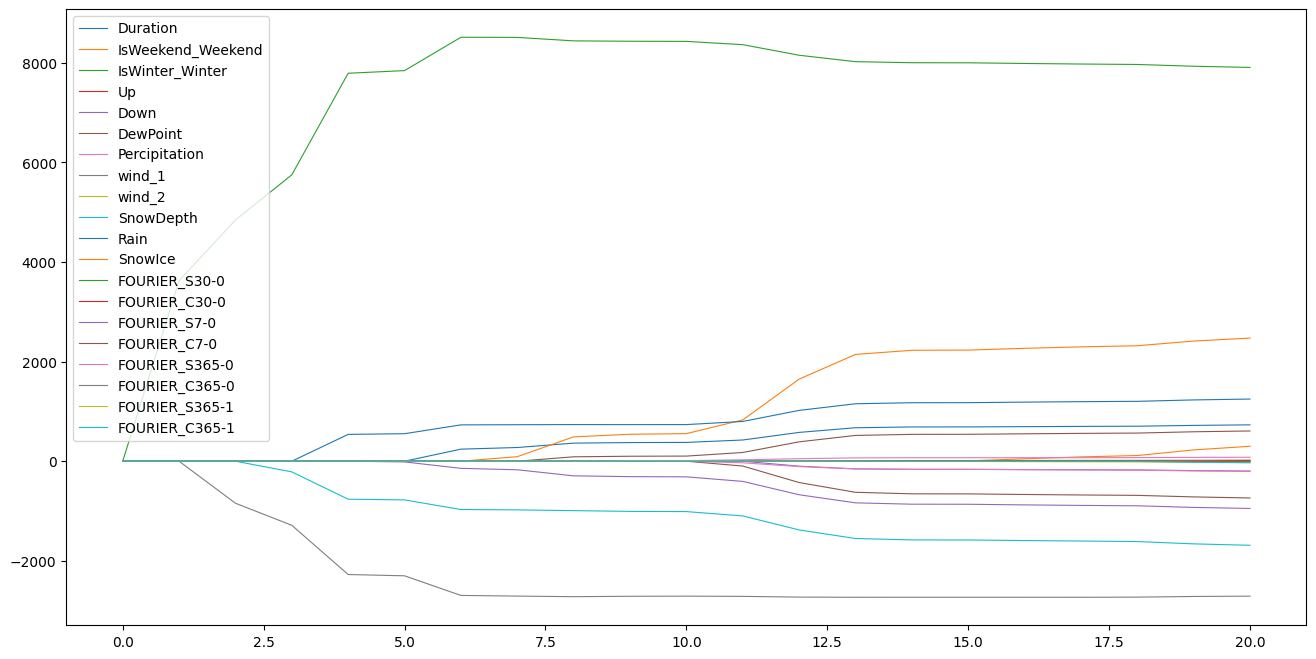

In [ ]:
_, _ , coefs = lars_path(X=my_model_data_train[['Duration', 'IsWeekend_Weekend', 'IsWinter_Winter', 'Up', 'Down', 'DewPoint', 'Percipitation', 'wind_1', 'wind_2', 'SnowDepth', 'Rain', 'SnowIce', 'FOURIER_S30-0', 'FOURIER_C30-0', 'FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0', 'FOURIER_S365-1', 'FOURIER_C365-1']].values, y=my_model_data_train['volume_tot'], method="lasso")
pd.DataFrame(coefs.T,columns=['Duration', 'IsWeekend_Weekend', 'IsWinter_Winter', 'Up', 'Down', 'DewPoint', 'Percipitation', 'wind_1', 'wind_2', 'SnowDepth', 'Rain', 'SnowIce', 'FOURIER_S30-0', 'FOURIER_C30-0', 'FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0', 'FOURIER_S365-1', 'FOURIER_C365-1']).plot(figsize=(16,8),linewidth=0.8)

In [ ]:
pd.DataFrame(coefs.T,columns=['Duration', 'IsWeekend_Weekend', 'IsWinter_Winter', 'Up', 'Down', 'DewPoint', 'Percipitation', 'wind_1', 'wind_2', 'SnowDepth', 'Rain', 'SnowIce', 'FOURIER_S30-0', 'FOURIER_C30-0', 'FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0', 'FOURIER_S365-1', 'FOURIER_C365-1']).apply(lambda x: x.loc[abs(x)>0].head(1).index, axis=0).T.sort_values(0)

0
IsWinter_Winter     1
FOURIER_C365-0      2
SnowDepth           3
Rain                4
FOURIER_S7-0        5
Duration            6
IsWeekend_Weekend   7
FOURIER_C7-0        8
FOURIER_S365-0      9
Percipitation      10
DewPoint           11
Down               12
Up                 13
FOURIER_S365-1     14
SnowIce            15
wind_1             16
FOURIER_S30-0      17
FOURIER_C365-1     18
wind_2             19
FOURIER_C30-0      20

In [ ]:
feat_set = ['Duration', 'IsWeekend_Weekend', 'IsWinter_Winter', 'Up', 'Down', 'DewPoint', 'Percipitation', 'wind_1', 'wind_2', 'SnowDepth', 'Rain', 'SnowIce', 'FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0', 'FOURIER_S365-1']

In [ ]:
ridge_model = RidgeCV(alphas=[1e-2, 1e-1, 1, 1e1, 1e2],fit_intercept=True)
ridge_model.fit(my_model_data_train[feat_set], my_model_data_train['volume_tot'])


ridge_pred_train = ridge_model.predict(my_model_data_train[feat_set])
ridge_pred_test = ridge_model.predict(my_model_data_test[feat_set])


print('in Ridge MSE:', mean_squared_error(my_model_data_train['volume_tot'], ridge_pred_train))
print('out Ridge MSE:', mean_squared_error(my_model_data_test['volume_tot'], ridge_pred_test))


print('in R-squared:', ridge_model.score(my_model_data_train[feat_set], my_model_data_train['volume_tot']))
print('out R-squared:', ridge_model.score(my_model_data_test[feat_set], my_model_data_test['volume_tot']))


print('alpha: ',ridge_model.alpha_)

in Ridge MSE: 533849.6969318747
out Ridge MSE: 1161954.6183485773
in R-squared: 0.49790645921082854
out R-squared: -0.2407863542253892
alpha:  10.0


In [ ]:
stats.summary(ridge_model, my_model_data_train[feat_set], my_model_data_train['volume_tot'])

Residuals:
       Min        1Q  Median       3Q       Max
-3395.0362 -441.3723 25.9031 453.0345 2251.6609


Coefficients:
               Estimate  Std. Error   t value   p value
_intercept  6219.279727   59.205627  105.0454  0.000000
x1           387.369513   32.499473   11.9193  0.000000
x2          -406.519163  103.574381   -3.9249  0.000094
x3           118.861129  108.587048    1.0946  0.274006
x4             6.858049   28.071883    0.2443  0.807057
x5           -88.887071   28.517972   -3.1169  0.001892
x6          -374.643973   52.872711   -7.0858  0.000000
x7            25.378694   28.224012    0.8992  0.368816
x8           119.453245   28.774068    4.1514  0.000036
x9            49.370241   26.433434    1.8677  0.062158
x10         -265.354267   62.013523   -4.2790  0.000021
x11          -94.704479   62.849904   -1.5068  0.132238
x12         -254.677390  110.893874   -2.2966  0.021894
x13         -208.877312   31.061003   -6.7247  0.000000
x14           21.455329   29.413179  

In [ ]:
feat_set.remove('Up')
feat_set.remove('FOURIER_S365-1')

(-1.0, 10.45)

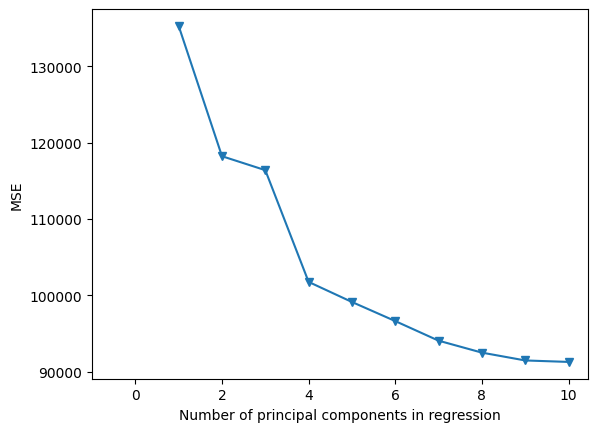

In [ ]:
cvfold = KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 11):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, my_model_data_train[feat_set],\
              my_model_data_train[['1.0', '2.0', '3.0', '4.0', '5.0']], cv=cvfold, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 11), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.xlim(xmin=-1)

In [ ]:
# Create the PLS model
pls_model = PLSRegression(n_components=4)

# Fit the model to the training data
pls_model.fit(my_model_data_train[feat_set],\
              my_model_data_train[['1.0', '2.0', '3.0', '4.0', '5.0']])

# Make predictions
Y_pred_train = pls_model.predict(my_model_data_train[feat_set])
Y_pred_test = pls_model.predict(my_model_data_test[feat_set])

print('in pls MSE:', mean_squared_error(my_model_data_train[['1.0', '2.0', '3.0', '4.0', '5.0']], Y_pred_train))
print('out pls MSE:', mean_squared_error(my_model_data_test[['1.0', '2.0', '3.0', '4.0', '5.0']], Y_pred_test))


print('in R-squared:', pls_model.score(my_model_data_train[feat_set], my_model_data_train[['1.0', '2.0', '3.0', '4.0', '5.0']]))
print('out R-squared:', pls_model.score(my_model_data_test[feat_set], my_model_data_test[['1.0', '2.0', '3.0', '4.0', '5.0']]))


in pls MSE: 96853.39699964588
out pls MSE: 137780.66481880384
in R-squared: 0.49353860268455635
out R-squared: -0.623655732319019


In [ ]:
tmp_df1 = pd.DataFrame(pls_model.coef_.astype(int), index = feat_set, columns=['1.0', '2.0', '3.0', '4.0', '5.0'])

In [ ]:
tmp_df2 = pd.DataFrame(pls_model.intercept_.astype(int), index=['1.0', '2.0', '3.0', '4.0', '5.0'],columns=['intercept']).T

In [ ]:
# merge two dataframe vertically
pd.concat([tmp_df1, tmp_df2], axis=0, ignore_index=False)

1.0   2.0  3.0  4.0   5.0
Duration            106   407    0   12  -139
IsWeekend_Weekend  -180  -136  -28  -22   160
IsWinter_Winter     -14     7   24   -4   -65
Down                 -3    70   -5    0    -7
DewPoint             18  -225    9    2    53
Percipitation        14   -42   -6    3    -1
wind_1               14   147  -15    3   -36
wind_2               15    -5   13    0   -16
SnowDepth            -6   -15    7    0   -54
Rain                 23  -114   -4    5     4
SnowIce             -20    37  -10   -1    -4
FOURIER_S7-0       -136  -146  -15  -17   118
FOURIER_C7-0         82    -7   19   10   -77
FOURIER_S365-0       42   -82  -31   12    -4
FOURIER_C365-0      -23    72   22   -6   -67
intercept          1498  2387  269  582  1382

## in the rolling window version, shift weather features so that we dont have look-ahead bias, but other features such as weekend / winter are all known in the timepoint when make predictions

In [ ]:
my_model_data[['Duration_7dago', 'Up_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago', 'wind_2_7dago', 'SnowDepth_7dago', 'Rain_7dago', 'SnowIce_7dago']] = my_model_data[['Duration', 'Up', 'Down', 'DewPoint', 'Percipitation', 'wind_1', 'wind_2', 'SnowDepth', 'Rain', 'SnowIce']].shift(7)

In [ ]:
my_model_data.drop(['Duration', 'Up', 'Down', 'DewPoint', 'Percipitation', 'wind_1', 'wind_2', 'SnowDepth', 'Rain', 'SnowIce'], axis=1, inplace=True)

<Figure size 1600x1600 with 0 Axes>

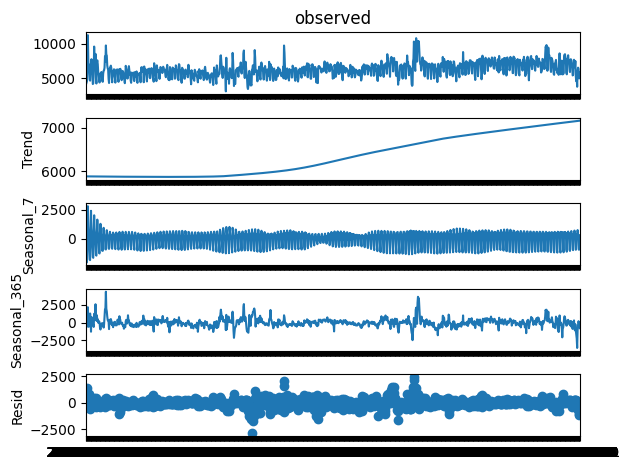

In [ ]:
from statsmodels.tsa.seasonal import MSTL
# 365 - 1  , 30 - 12 , 7 - 52
plt.figure(figsize=(16,16))
mstl_model = MSTL(my_model_data['volume_tot'], periods=(7, 365))
mstl_res = mstl_model.fit()
mstl_res.plot()
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(mstl_res.resid)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -6.701029
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


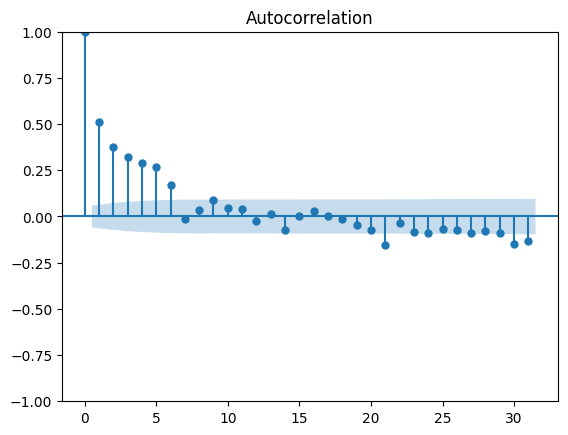

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(mstl_res.resid)
plt.show() # MA q = 6

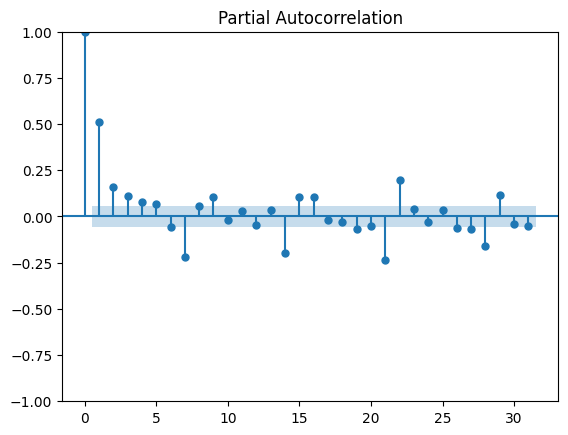

In [ ]:
plot_pacf(mstl_res.resid)
plt.show() # AR p = 3

## since we cannot have the next week volume value to predict the T+7 volume even though we know residual follow ARIMA(3,0,6) with seasonality from previous time series plot. Hence, as a turnaround, we add the T-8/9/10 residuals as predictor, as well as the long-term trend.

In [ ]:
my_model_data['resid'] = mstl_res.resid
my_model_data['trend'] = mstl_res.trend

In [ ]:
my_model_data[['res_8dago']] = my_model_data[['resid']].shift(8)
my_model_data[['res_9dago']] = my_model_data[['resid']].shift(9)
my_model_data[['res_10dago']] = my_model_data[['resid']].shift(10)

In [ ]:
my_model_data[['Duration_7dago', 'Up_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago', 'wind_2_7dago', 'SnowDepth_7dago', 'Rain_7dago', 'SnowIce_7dago', 'res_8dago', 'res_9dago', 'res_10dago']]=\
my_model_data[['Duration_7dago', 'Up_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago', 'wind_2_7dago', 'SnowDepth_7dago', 'Rain_7dago', 'SnowIce_7dago', 'res_8dago', 'res_9dago', 'res_10dago']].fillna(my_model_data.groupby(['IsWeekend_Weekend', 'IsWinter_Winter'])[['Duration_7dago', 'Up_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago', 'wind_2_7dago', 'SnowDepth_7dago', 'Rain_7dago', 'SnowIce_7dago', 'res_8dago','res_9dago','res_10dago']].transform('mean'))

In [ ]:
linear_output = pd.DataFrame(np.nan, index=my_model_data.index, columns=['BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND','Unspecified','volume_tot','1.0','2.0','3.0','4.0','5.0','mse_borough','mse_cluster','mse_tot','volume_tot_t8','mse_tot_t8'])

In [ ]:
for ele in ['Duration','Down',
 'DewPoint',
 'Percipitation',
 'wind_1','wind_2',
 'SnowDepth',
 'Rain',
 'SnowIce']:
 feat_set.remove(ele)
 feat_set.append(ele+'_7dago')

In [ ]:
ts_set = ['trend','res_8dago','res_9dago','res_10dago']

In [ ]:
for train_end_idx in range(829, len(my_model_data)-6, 7): #

    my_model_data_train = my_model_data.iloc[train_end_idx-821:train_end_idx]
    my_model_data_test = my_model_data.iloc[train_end_idx:train_end_idx+7]

    # Scale numeric features all at once
    scaler = StandardScaler()
    my_model_data_train[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago', 'SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set] = scaler.fit_transform(my_model_data_train[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago', 'wind_2_7dago','SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set])
    my_model_data_test[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago', 'SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set] = scaler.transform(my_model_data_test[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago', 'wind_2_7dago','SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set])

    # Create the PLS model
    pls_model = PLSRegression(n_components=5)

    # Fit the model to the training data
    pls_model.fit(my_model_data_train[feat_set+['trend']],\
              my_model_data_train[['1.0', '2.0', '3.0', '4.0', '5.0']])

    # Make predictions
    Y_pred_test = pls_model.predict(my_model_data_test[feat_set+['trend']])

    # report performance
    out_mse = mean_squared_error(my_model_data_test[['1.0', '2.0', '3.0', '4.0', '5.0']], Y_pred_test)

    # store
    linear_output.loc[my_model_data_test.index, ['1.0', '2.0', '3.0', '4.0', '5.0']] = Y_pred_test
    linear_output.loc[my_model_data_test.index[-1], ['mse_cluster']] = out_mse

In [ ]:
for train_end_idx in range(823, len(my_model_data)-6, 7): #

    my_model_data_train = my_model_data.iloc[train_end_idx-821:train_end_idx]
    my_model_data_test = my_model_data.iloc[train_end_idx:train_end_idx+7]

    # Scale numeric features all at once
    scaler = StandardScaler()
    my_model_data_train[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago', 'SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set] = scaler.fit_transform(my_model_data_train[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago', 'wind_2_7dago','SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set])
    my_model_data_test[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago', 'SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set] = scaler.transform(my_model_data_test[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago', 'wind_2_7dago','SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set])

    ridge_model = Ridge(alpha=10,fit_intercept=True)
    ridge_model.fit(my_model_data_train[feat_set+['trend']], my_model_data_train['volume_tot'])


    Y_pred_test = ridge_model.predict(my_model_data_test[feat_set+['trend']])

    # report performance
    out_mse = mean_squared_error(my_model_data_test['volume_tot'], Y_pred_test)

    # store
    linear_output.loc[my_model_data_test.index, ['volume_tot']] = Y_pred_test.reshape(-1,1)
    linear_output.loc[my_model_data_test.index[-1], ['mse_tot']] = out_mse

In [ ]:
for train_end_idx in range(823, len(my_model_data)-6, 7): #

    my_model_data_train = my_model_data.iloc[train_end_idx-821:train_end_idx]
    my_model_data_test = my_model_data.iloc[train_end_idx:train_end_idx+7]

    # Scale numeric features all at once
    scaler = StandardScaler()
    my_model_data_train[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago', 'SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set] = scaler.fit_transform(my_model_data_train[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago', 'wind_2_7dago','SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set])
    my_model_data_test[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago', 'SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set] = scaler.transform(my_model_data_test[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago', 'wind_2_7dago','SnowDepth_7dago','FOURIER_S7-0', 'FOURIER_C7-0', 'FOURIER_S365-0', 'FOURIER_C365-0']+ts_set])

    ridge_model = Ridge(alpha=10,fit_intercept=True)
    ridge_model.fit(my_model_data_train[feat_set+ts_set], my_model_data_train['volume_tot'])


    Y_pred_test = ridge_model.predict(my_model_data_test[feat_set+ts_set])

    # report performance
    out_mse = mean_squared_error(my_model_data_test['volume_tot'], Y_pred_test)

    # store
    linear_output.loc[my_model_data_test.index, ['volume_tot_t8']] = Y_pred_test.reshape(-1,1)
    linear_output.loc[my_model_data_test.index[-1], ['mse_tot_t8']] = out_mse

<Axes: xlabel='Created Date'>

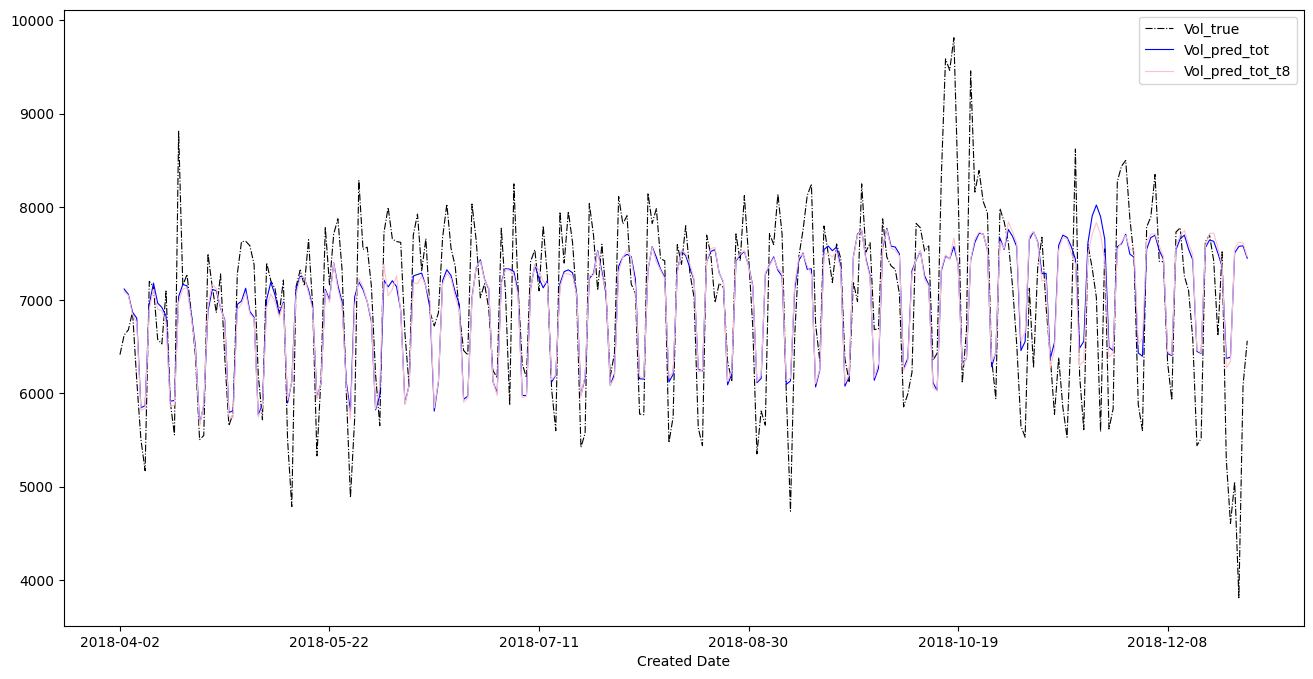

In [ ]:
plt.figure(1, figsize=(16,8))
my_model_data.iloc[822:-2]['volume_tot'].plot(c='black',label='Vol_true',legend=True,linewidth=0.8,linestyle='-.')
linear_output.iloc[822:-2]['volume_tot'].plot(c='blue',label='Vol_pred_tot',legend=True,linewidth=0.8,linestyle='-')
#linear_output.iloc[822:-2][['BRONX','BROOKLYN',	'MANHATTAN','QUEENS','STATEN ISLAND','Unspecified']].sum(axis=1).plot(c='green',label='Vol_pred_borough',legend=True,linewidth=0.8,linestyle='-')
#linear_output.iloc[822:-2][['1.0','2.0','3.0','4.0','5.0']].sum(axis=1).plot(c='red',label='Vol_pred_cluster',legend=True,linewidth=0.8,linestyle='-')
linear_output.iloc[822:-2]['volume_tot_t8'].plot(c='pink',label='Vol_pred_tot_t8',legend=True,linewidth=0.8,linestyle='-')

In [ ]:
linear_output['mse_borough_tot'] = ((linear_output[['BRONX','BROOKLYN',	'MANHATTAN','QUEENS','STATEN ISLAND','Unspecified']].sum(axis=1)-my_model_data['volume_tot'])**2).rolling(7).mean()

In [ ]:
linear_output['mse_cluster_tot'] = ((linear_output[['1.0','2.0','3.0','4.0','5.0']].sum(axis=1)-my_model_data['volume_tot'])**2).rolling(7).mean()

Text(0, 0.5, 'mse from different rolling-window regression')

<Figure size 640x480 with 0 Axes>

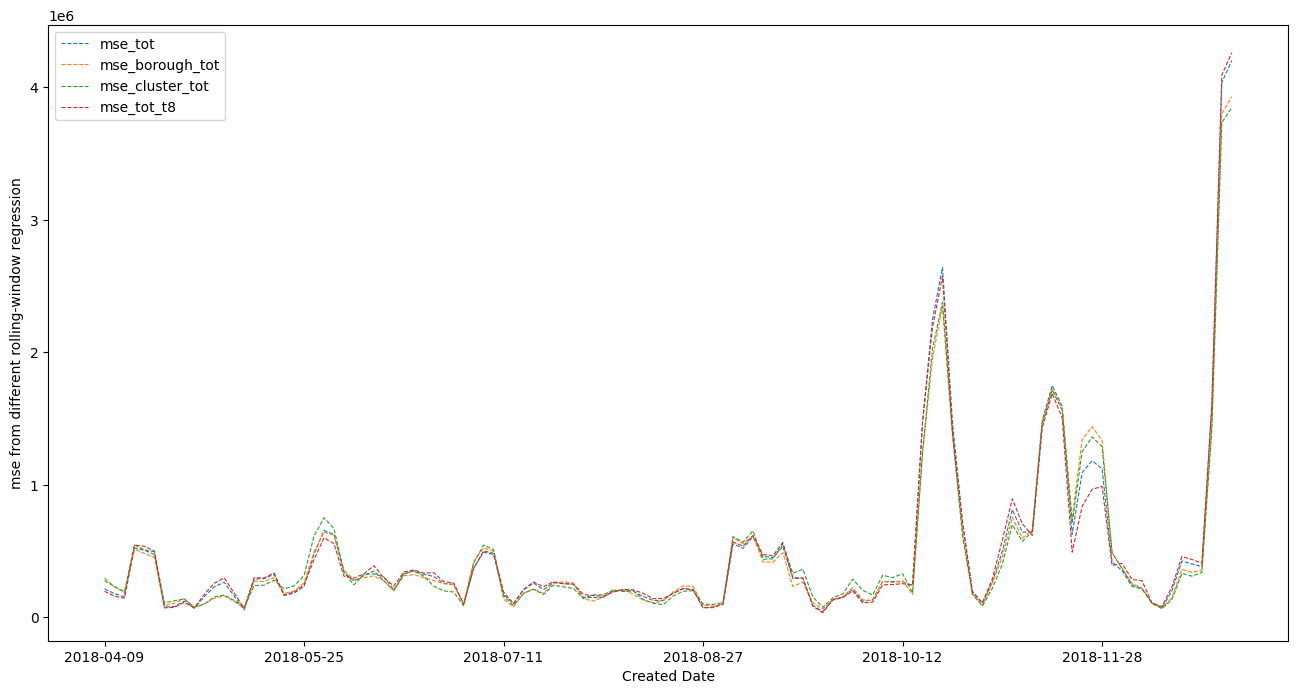

In [10]:
plt.figure(2)
ax = linear_output.iloc[822:-2][['mse_tot','mse_borough_tot','mse_cluster_tot','mse_tot_t8']].dropna(how='any').plot(legend=True,linewidth=0.8,linestyle='--',figsize=(16,8))
plt.ylabel("mse from different rolling-window regression")

In [15]:
linear_output.iloc[822:-2][['mse_tot','mse_borough_tot','mse_cluster_tot','mse_tot_t8']].dropna(how='any').mean()

mse_tot            476658.881092
mse_borough_tot    462760.644922
mse_cluster_tot    466575.706019
mse_tot_t8         474845.200844
dtype: float64

## we first separate training and testing set like the linear models (first 621 samples as training set, so that we could cover lookback window), and spent a decent amount of time to train the LSTM using multiple epochs by re-sampling the training set. Then, we fixed the model and evaluate its performance for all samples from the test set.

## Finally, we switch to the weekly rolling window approach where take our trained LSTM as a starting point. In each weekly step of the loop, we feed the new batch (7 samples) to the LSTM to do one more batch training, then use the updated LSTM to predict the next week out-of-sample performance, until running out of the entire test set.

In [ ]:
my_model_data_train = my_model_data.iloc[:621]
my_model_data_test = my_model_data.iloc[621:]

In [ ]:
scaler = StandardScaler()
my_model_data_train[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago','SnowDepth_7dago']+ts_set] = scaler.fit_transform(my_model_data_train[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago','SnowDepth_7dago']+ts_set])
my_model_data_test[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago','SnowDepth_7dago']+ts_set] = scaler.transform(my_model_data_test[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago','SnowDepth_7dago']+ts_set])

In [ ]:
lookback=360

In [ ]:
# my_train_tensor = torch.FloatTensor([my_model_data_train[feat_set+['trend','volume_tot']][start:start+lookback].to_numpy() for start in range(1,len(my_model_data_train[feat_set+['trend','volume_tot']])-lookback)])
# my_train_tensor = my_train_tensor.to(device)

In [ ]:
my_train_tensor = torch.FloatTensor([my_model_data_train[feat_set+ts_set+['volume_tot']][start:start+lookback].to_numpy() for start in range(1,len(my_model_data_train[feat_set+ts_set+['volume_tot']])-lookback)])
my_train_tensor = my_train_tensor.to(device)

In [ ]:
my_train_tensor_x = my_train_tensor[:,:,:-1]
my_train_tensor_y = my_train_tensor[:,:,-1:]
print(my_train_tensor_x.shape, my_train_tensor_y.shape)

torch.Size([260, 360, 19]) torch.Size([260, 360, 1])


In [ ]:
# my_test_tensor = torch.FloatTensor([my_model_data_test[feat_set+['trend','volume_tot']][start:start+lookback].to_numpy() for start in range(1,len(my_model_data_test[feat_set+['trend','volume_tot']])-lookback)])
# my_test_tensor = my_test_tensor.to(device)

In [ ]:
my_test_tensor = torch.FloatTensor([my_model_data_test[feat_set+ts_set+['volume_tot']][start:start+lookback].to_numpy() for start in range(1,len(my_model_data_test[feat_set+ts_set+['volume_tot']])-lookback)])
my_test_tensor = my_test_tensor.to(device)

In [ ]:
my_test_tensor_x = my_test_tensor[:,:,:-1]
my_test_tensor_y = my_test_tensor[:,:,-1:]
print(my_test_tensor_x.shape, my_test_tensor_y.shape)

torch.Size([114, 360, 19]) torch.Size([114, 360, 1])


In [ ]:
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(my_train_tensor_x, my_train_tensor_y), shuffle=True, batch_size=30)

In [ ]:
loss_fn = nn.MSELoss()

In [ ]:
train_loss_hist = []
val_loss_hist = []

In [ ]:
class CSFB_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=15, hidden_size=4, num_layers=2, batch_first=True, bias=True, dropout=0.5)
        self.linear_ts = nn.Linear(3, 1)
        self.linear_lstm = nn.Linear(4, 1)
        self.linear_out = nn.Linear(3, 1)
        self.bn = nn.BatchNorm1d(1)
        self.drop = nn.Dropout(0.1)
        self.ts_relu = nn.LeakyReLU(0.1)


    def forward(self, x):

        # weather nonlinear
        x_out, _ = self.lstm(x[:,:,:-4])
        x_out = self.linear_lstm(x_out)

        # ts nonlinear
        x_ts = self.linear_ts(x[:,:,-3:])
        x_ts = self.drop(x_ts)

        # ts linear
        x_out_ts = self.linear_out(torch.cat((x_out, x_ts, x[:,:,-4:-3]), 2))
        return x_out_ts

In [ ]:
dl_model = CSFB_Model().to(device)

In [ ]:
optimizer = optim.Adam(dl_model.parameters(),lr=0.005, betas=(0.9, 0.999), weight_decay=0.5)

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
early_stopper = EarlyStopper(patience=5, min_delta=5e5)

In [ ]:
# n_epochs = int(0.7e4)

# for epoch in range(5000,n_epochs):

#     dl_model.train()
#     for X_batch, y_batch in loader:
#         y_pred = dl_model(X_batch.to(device))
#         loss = loss_fn(y_pred, y_batch.to(device))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # Validation
#     dl_model.eval()
#     with torch.no_grad():
#         y_pred = dl_model(my_train_tensor_x)
#         train_mse = loss_fn(y_pred, my_train_tensor_y)
#         y_pred = dl_model(my_test_tensor_x)
#         test_mse = loss_fn(y_pred, my_test_tensor_y)
#     train_loss_hist.append(train_mse)
#     val_loss_hist.append(test_mse)

#     # if early stop
#     if early_stopper.early_stop(test_mse):
#         print('early stopped')
#         break

#     # if save
#     if epoch % 2000 == 0 and epoch > 0:
#         # Specify a path to save to
#         PATH = "/content/drive/MyDrive/Colab Notebooks/Pt72_MI/dl_model"+ str(epoch)+ ".pt"
#         # Save
#         torch.save(dl_model.state_dict(), PATH)

#     # if print
#     if epoch % 100 != 0:
#         continue
#     print("Epoch %d: train MSE %.4f, test MSE %.4f" % (epoch, train_mse, test_mse))


Epoch 5000: train MSE 872550.1250, test MSE 847755.1875
Epoch 5100: train MSE 330935.0938, test MSE 1083393.5000
Epoch 5200: train MSE 317451.5312, test MSE 1069095.6250
Epoch 5300: train MSE 306194.0000, test MSE 1059640.1250
Epoch 5400: train MSE 304247.6250, test MSE 1037950.3750
Epoch 5500: train MSE 314654.2812, test MSE 976441.0000
Epoch 5600: train MSE 307567.5000, test MSE 996969.6250
Epoch 5700: train MSE 307324.3125, test MSE 1075668.3750
Epoch 5800: train MSE 314419.7188, test MSE 1018908.3750
Epoch 5900: train MSE 308008.3438, test MSE 1008823.7500
Epoch 6000: train MSE 309519.7812, test MSE 1018799.1250
Epoch 6100: train MSE 309177.0625, test MSE 988870.4375
Epoch 6200: train MSE 311892.8750, test MSE 975709.1250
Epoch 6300: train MSE 306569.7188, test MSE 983211.0000
Epoch 6400: train MSE 306145.0000, test MSE 958605.8750
Epoch 6500: train MSE 300930.8438, test MSE 978249.0000
Epoch 6600: train MSE 298063.5000, test MSE 1024463.4375
Epoch 6700: train MSE 293770.0312, test

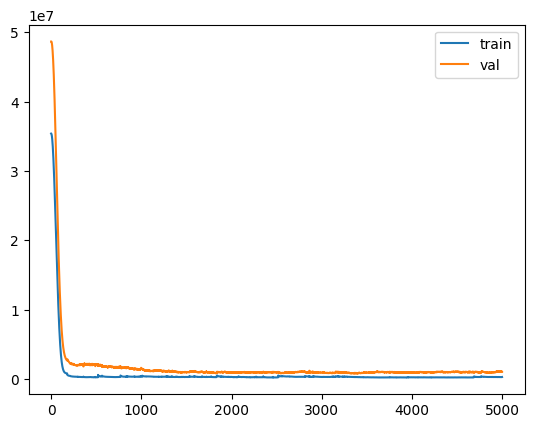

In [ ]:
plt.figure(3)
l1, = plt.plot([ele.to(torch.device('cpu')) for ele in train_loss_hist[-7000:]])
l2, = plt.plot([ele.to(torch.device('cpu')) for ele in val_loss_hist[-7000:]])
plt.legend(handles=[l1,l2], labels = ['train','val'], loc='best')

In [ ]:
lstm_output = pd.DataFrame(np.nan, index=my_model_data.index, columns=['volume_tot_lstm','volume_tot_rolling_retrain'])

In [ ]:
step = 7
dl_model.eval()
with torch.no_grad():
    for train_end_idx in range(lookback, len(my_model_data), step): #

      my_model_data_tmp = my_model_data.iloc[train_end_idx-lookback:train_end_idx]
      scaler = StandardScaler()
      my_model_data_tmp[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago','SnowDepth_7dago']+ts_set] = scaler.fit_transform(my_model_data_tmp[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago','SnowDepth_7dago']+ts_set])

      cur_week_forecast = dl_model(torch.FloatTensor(my_model_data_tmp[feat_set+ts_set].to_numpy()).unsqueeze(0).to(device))[:,-step:,:].to(torch.device('cpu')).numpy().squeeze()
      lstm_output.loc[my_model_data.index[train_end_idx-step:train_end_idx] , 'volume_tot_lstm'] = cur_week_forecast

In [ ]:
step = 7
for train_end_idx in range(lookback, len(my_model_data)-7, step): #

      my_model_data_tmp = my_model_data.iloc[train_end_idx-lookback : train_end_idx]
      my_model_data_tmp2 = my_model_data.iloc[train_end_idx+7-lookback : train_end_idx+7]

      scaler = StandardScaler()
      my_model_data_tmp[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago','SnowDepth_7dago']+ts_set] = scaler.fit_transform(my_model_data_tmp[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago','SnowDepth_7dago']+ts_set])
      my_model_data_tmp2[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago','SnowDepth_7dago']+ts_set] = scaler.fit_transform(my_model_data_tmp2[['Duration_7dago', 'Down_7dago', 'DewPoint_7dago', 'Percipitation_7dago', 'wind_1_7dago','wind_2_7dago','SnowDepth_7dago']+ts_set])

      dl_model.train()
      y_pred = dl_model(torch.FloatTensor(my_model_data_tmp[feat_set+ts_set].to_numpy()).unsqueeze(0).to(device)[:,:,:])
      y_tmp_test = torch.FloatTensor(my_model_data_tmp['volume_tot'].to_numpy()).unsqueeze(0).to(device)[:,:].unsqueeze(-1)
      loss = loss_fn(y_pred, y_tmp_test)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      dl_model.eval()
      with torch.no_grad():
        nex_week_forecast = dl_model(torch.FloatTensor(my_model_data_tmp2[feat_set+ts_set].to_numpy()).unsqueeze(0).to(device)).to(torch.device('cpu')).numpy().squeeze()
        lstm_output.loc[my_model_data.index[train_end_idx:train_end_idx+7] , 'volume_tot_rolling_retrain'] = nex_week_forecast[-7:]

<Axes: xlabel='Created Date'>

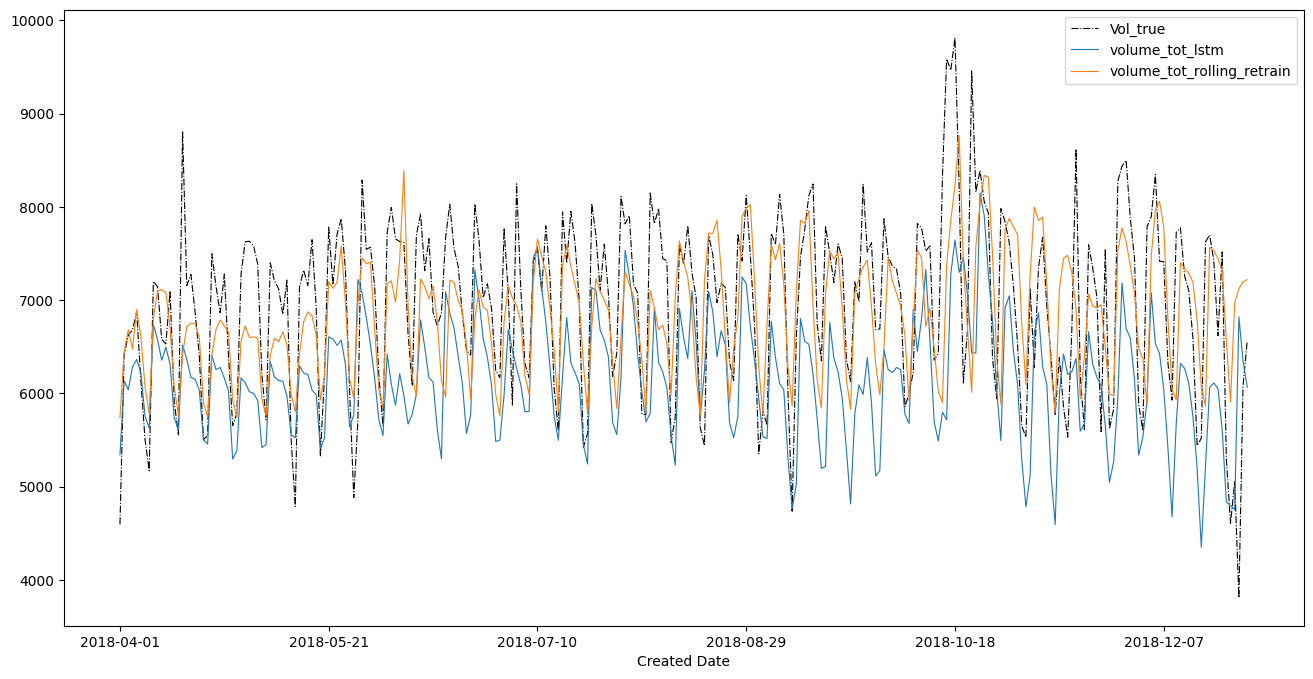

In [ ]:
ax = my_model_data['volume_tot'].iloc[821:-4].plot(c='black',label='Vol_true',legend=True,linewidth=0.8,linestyle='-.',figsize=(16,8))
lstm_output.iloc[821:-4].plot(ax=ax,linewidth=0.8,linestyle='-')

In [ ]:
lstm_output['volume_tot_lstm_diff'] = lstm_output['volume_tot_lstm'] - my_model_data['volume_tot']
lstm_output['volume_tot_rolling_retrain_diff'] = lstm_output['volume_tot_rolling_retrain'] - my_model_data['volume_tot']

In [ ]:
lstm_output['volume_tot_lstm_mse'] = (lstm_output['volume_tot_lstm_diff'] ** 2).rolling(7).mean()
lstm_output['volume_tot_rolling_retrain_mse'] = (lstm_output['volume_tot_rolling_retrain_diff'] ** 2).rolling(7).mean()

<Axes: xlabel='Created Date'>

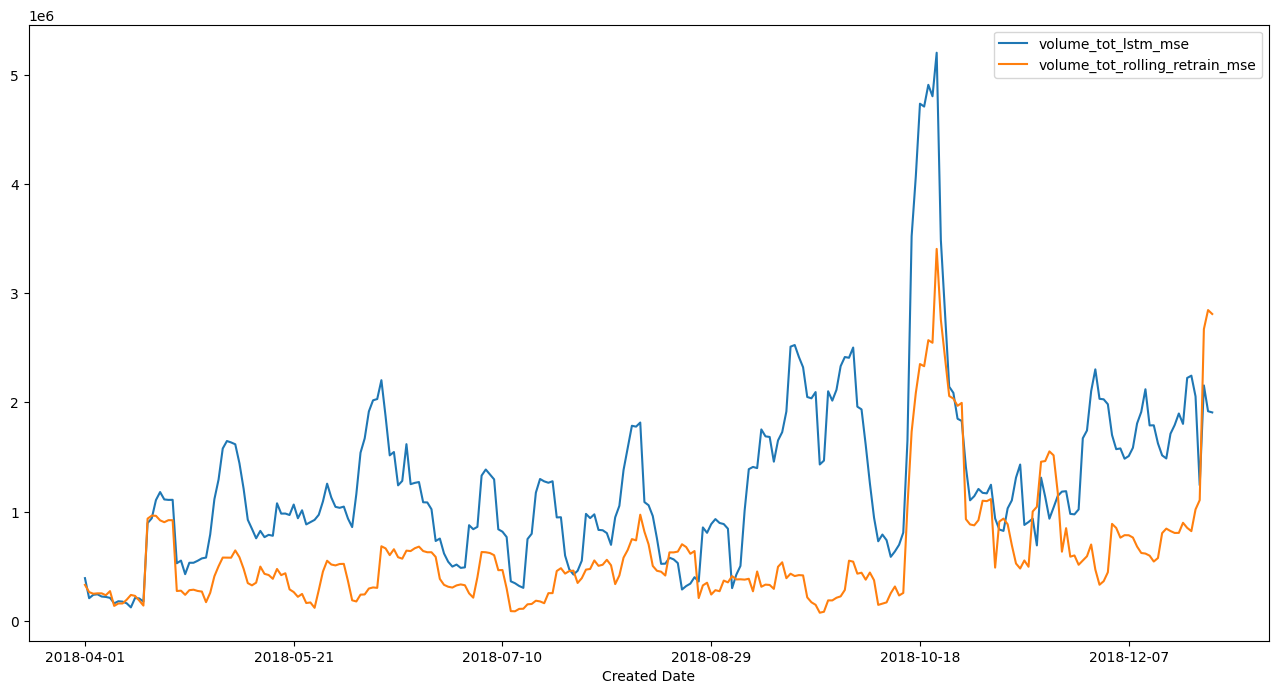

In [ ]:
lstm_output[['volume_tot_lstm_mse','volume_tot_rolling_retrain_mse']].iloc[821:-4].plot(figsize=(16,8))

In [ ]:
lstm_output[['volume_tot_lstm_mse','volume_tot_rolling_retrain_mse']].iloc[821:-4].mean()

volume_tot_lstm_mse               1.261619e+06
volume_tot_rolling_retrain_mse    6.098049e+05
dtype: float64

# 5. summary

## See the research paper